# Preambule

In [1]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import cv2

# try: cv2.setNumThreads(0)
# except: pass
from caiman import movie
import os
# %matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
from itertools import product
from collections import OrderedDict

from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))

from physio_def_1 import *
from matplotlib.colors import LogNorm

from numeric import *
from collections import Counter

# Importing

In [2]:
npzFile = "local_data/Sandra/2020_01_14/Experiment45b/Experiment45b_1_Series006.npz"
# npzFile = f"/Volumes/physio/team/slakrupnik/project/experiments/Sandra/{row.date}/{row.filename.split('_')[0]}/{row.filename}.npz"
metadata = pd.read_csv(npzFile.replace("npz","txt")).loc[0]
metadata

T          128000
X             128
Y             128
freq      84.3037
pxSize    1.93922
pxUnit         µm
Name: 0, dtype: object

In [3]:
metadata["T"]/metadata.freq/60

25.30534769828321

In [ ]:
npzData = np.load(npzFile)
orig_images = npzData["data"]
m_orig = movie(orig_images)
m_orig = m_orig.astype(float)

In [ ]:
time = np.arange(len(m_orig)).astype(np.float32)/metadata.freq

In [ ]:
Counter((np.diff(time)*1000).astype(int)/1000)

In [ ]:
m_orig.fr = metadata.freq
print (time.max()/60)
allTrace = m_orig.mean((1,2))
Nsatur = np.sum(m_orig>m_orig.max()-1, axis=(1,2))

In [ ]:
plt.plot(allTrace)
plt.twinx()
plt.plot(Nsatur,"C1",lw=.5)

# average to save time and memory, especially if there are waves

In [9]:
metadata.freq

99.05349375157736

In [10]:
newFreq = 30
tWin = int(np.ceil(m_orig.fr/newFreq))
newFreq = m_orig.fr/tWin
newFreq,tWin

(24.76337343789434, 4)

In [11]:
print("New period will be %.1fms"%(1000./newFreq))

New period will be 40.4ms


In [12]:
m_resized = m_orig.resize(1,1,newFreq/m_orig.fr)*tWin

In [13]:
m_orig = m_resized.copy()
del m_resized

# First glimpse analysis

In [ ]:
m_orig.debleach?

In [13]:
m_debleached = m_orig.debleach()

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/caiman/base/movies.py:535: UserWarning: Casting the array to float32
  warnings.warn('Casting the array to float32')


In [14]:
saveRes = OrderedDict()

In [15]:
m_orig.local_correlations??

In [30]:
# from caiman.summary_images import local_correlations_fft
# from caiman.summary_images import local_correlations

In [27]:
# %%capture
# cfft =  local_correlations_fft(m_orig[:5000],eight_neighbours=True,swap_dim=False)

# %%capture
# c0 = m_orig[:5000].local_correlations(eight_neighbours=True,swap_dim=False)

# %%capture
# c00 = local_correlations(m_orig[:5000], eight_neighbours=True,swap_dim=False)

# np.abs(c0-cfft).max(), np.abs(c0-c00).max(), np.abs(cfft-c00).max()

# %matplotlib notebook

# fig, axs = plt.subplots(1,3,figsize=(10,3), sharey=True, sharex=True)
# for ax,im in zip(axs, [c00,c0,cfft]):
#     ax.imshow(im, vmin=-1, vmax=1, cmap="bwr")

In [105]:
%%capture
%%time
saveRes.update(OrderedDict([
    ("orig_cc", m_orig.local_correlations(eight_neighbours=True,swap_dim=False)),
    ("debleached_cc", m_debleached.local_correlations(eight_neighbours=True,swap_dim=False)),
    ("debleached_mean", m_debleached.mean(0)),
    ("debleached_std", m_debleached.std(0)),
]))

In [131]:
dm_debleached.local_correlations?

In [106]:
%%capture
dm_debleached = np.diff(m_debleached,axis=0)
saveRes.update(OrderedDict([
    ("ddbl_mean", dm_debleached.mean(0)),
    ("ddbl_std", dm_debleached.std(0)),
    ("ddbl_cc", dm_debleached.local_correlations(eight_neighbours=True,swap_dim=False)),
]))

In [107]:
%%capture
dm_orig = np.diff(m_debleached,axis=0)
saveRes.update(OrderedDict([
    ("dOrig_mean", dm_orig.mean(0)),
    ("dOrig_std", dm_orig.std(0)),
    ("dOrig_cc", dm_orig.local_correlations(eight_neighbours=True,swap_dim=False)),
]))

In [108]:
# plt.imshow(np.abs(saveRes["debleached_cc"]-saveRes["orig_cc"]))
# plt.colorbar()
# plt.imshow(np.abs(saveRes["debleached_cc"]/(saveRes["orig_cc"]+1e-3)-1), norm=LogNorm())
# plt.colorbar()
# plt.imshow(saveRes["orig_cc"])
# plt.colorbar()
# plt.imshow(saveRes["debleached_cc"])
# plt.colorbar()

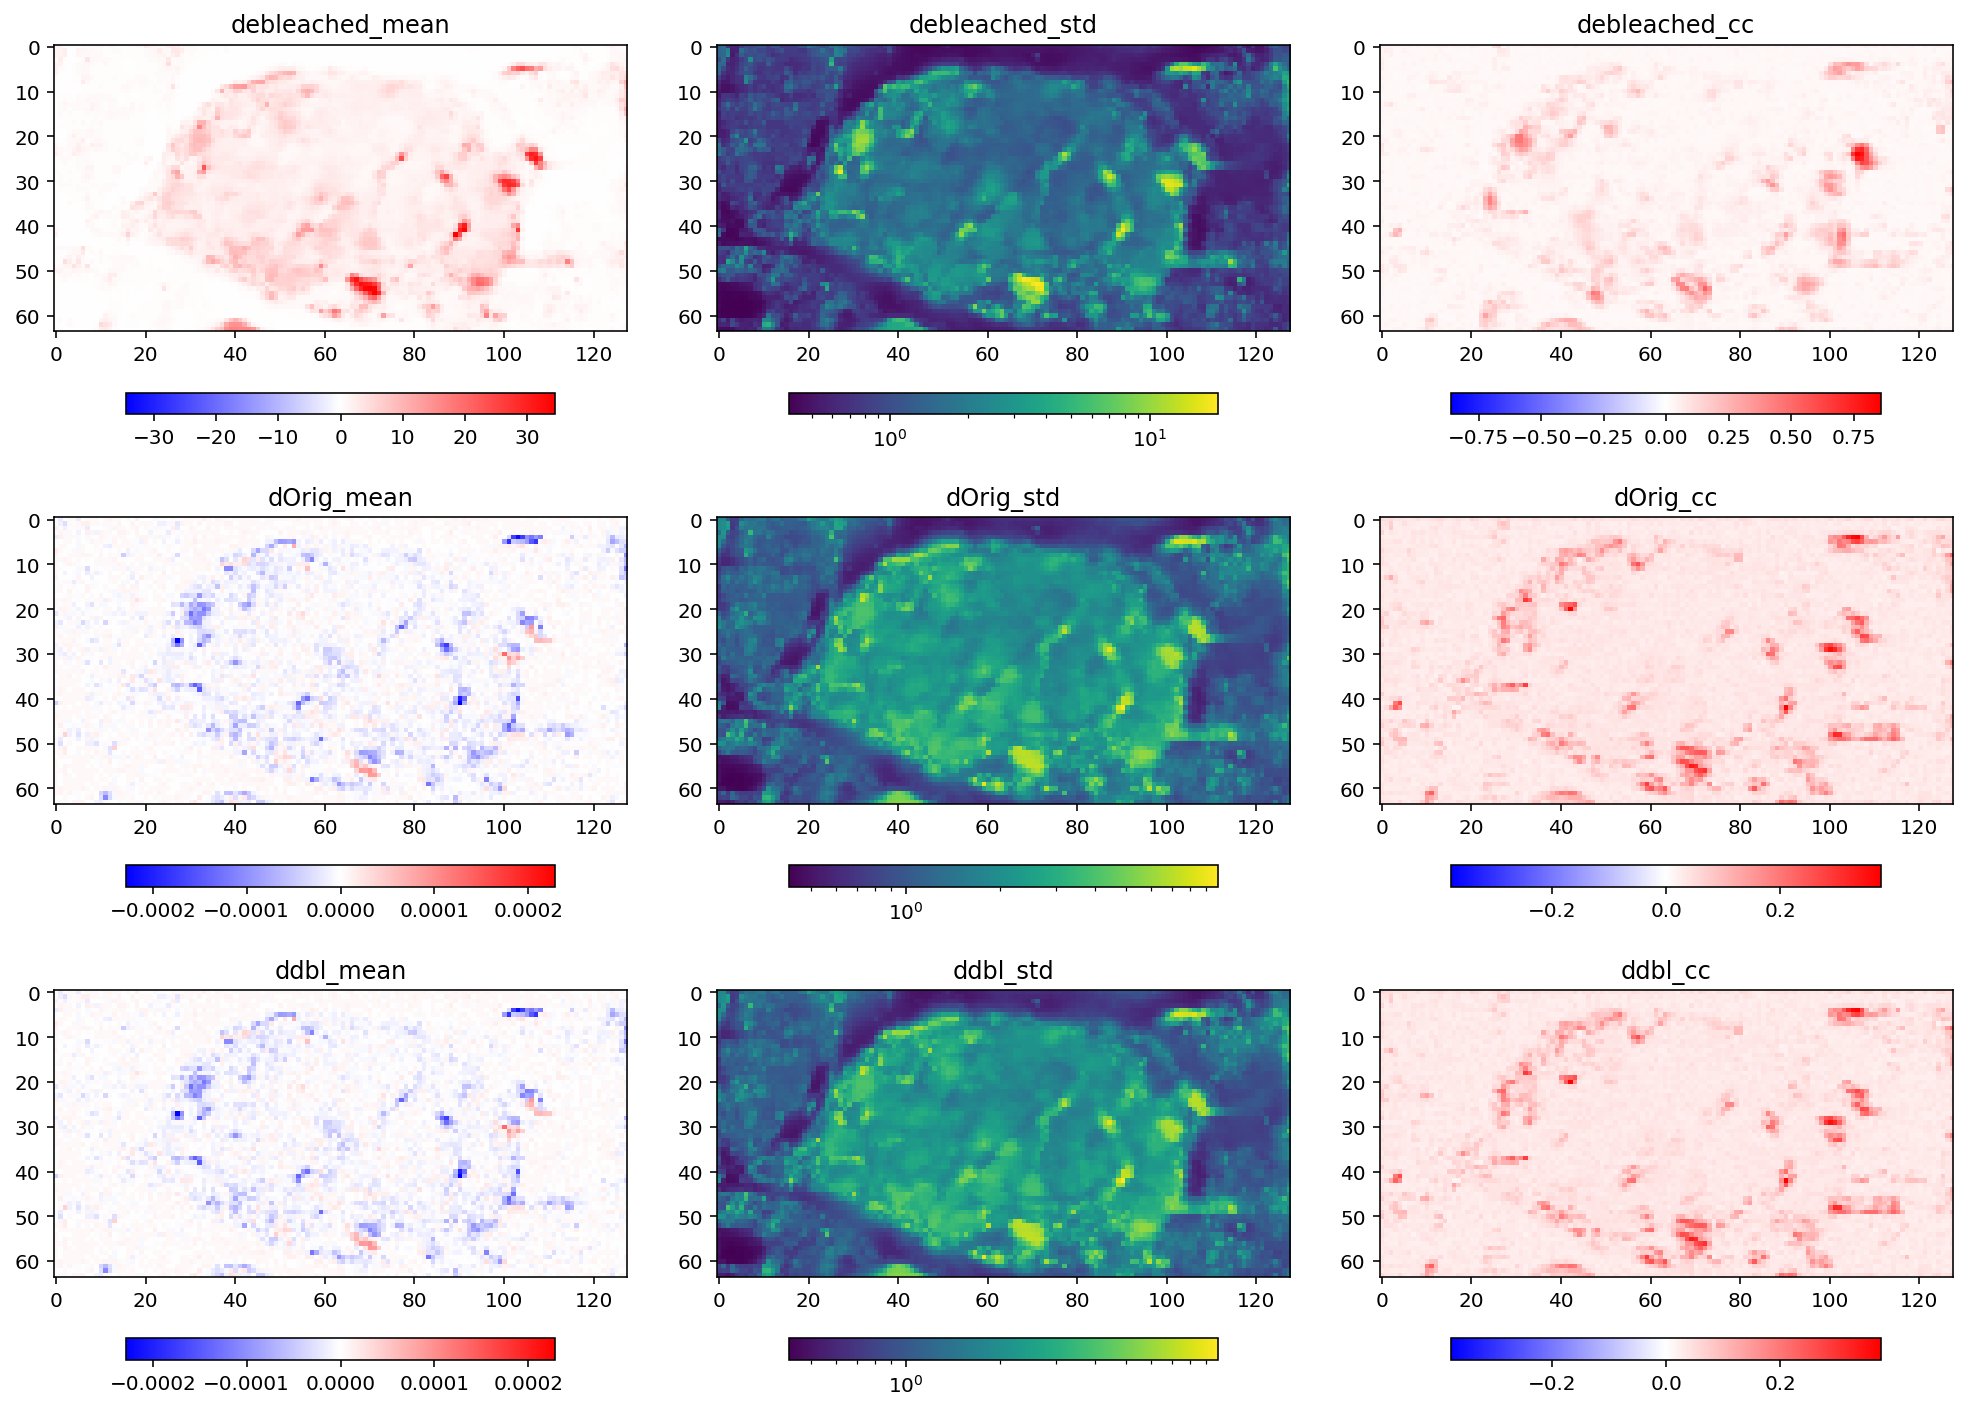

In [246]:
# fig, axs = plt.subplots(2,3,figsize=(12,8))
fig, axs = plt.subplots(3,3,figsize=(14,10))

for ax,mt in zip(axs.flat,[
    "debleached_mean", "debleached_std", "debleached_cc",
    "dOrig_mean", "dOrig_std", "dOrig_cc",
    "ddbl_mean", "ddbl_std", "ddbl_cc",
                          ]):
    ax.set_title(mt)
    try:
#         m = eval(mt)
        m = saveRes[mt]
    except:
        continue
    if np.any(m<0) or 'cc' in mt:
        im = ax.imshow(m,cmap="bwr",vmax=np.abs(m).max(),vmin=-np.abs(m).max())
    else:
        im = ax.imshow(m,norm=LogNorm())
    plt.colorbar(im,ax=ax,shrink=.7,orientation="horizontal")
fig.tight_layout()

In [110]:
n,s = 3,.3
blurredWeights = cv2.GaussianBlur(saveRes["dOrig_std"],(n,n),s)
plt.imshow(blurredWeights,norm=LogNorm())

# Define ROIs

In [600]:
# some definitions
def climb(x,blurredWeights,diag=True):
    dims = blurredWeights.shape
    # x = (60,60)
    x = x+(blurredWeights[x[0],x[1]],)
    xs = [x]
    # vs = pd.DataFrame(columns=["i","j","v"])
    for i in range(20):
        vs = []
        for di,dj in product([-1,0,1],[-1,0,1]):
            if not diag:
                if di*dj!=0: continue
            i,j = x[0]+di,x[1]+dj
            if i<0 or i>=dims[0] or j<0 or j>=dims[1]:
#                 print ("skipping")
                continue
        #     vs = vs.append({"i":i,"j":j,"v":blurredWeights[i,j]},ignore_index=True)
            vs += [(i,j,blurredWeights[i,j])]

        x1 = vs[np.argmax(vs,axis=0)[-1]]
        if x1[-1]<=x[-1]:
            break
        else:
            x = x1
            xs += [x]
    return x[:2]

def crawlDict(image, th=0, diag=False):
    A_ = [(i,j)+climb((i,j),image,diag=diag) for i,j in product(range(image.shape[0]),range(image.shape[1])) if image[i,j]>th]
    B_ = OrderedDict()
    for (i0,j0,i1,j1) in A_:
        if (i1,j1) not in B_:
            B_[(i1,j1)] = []
        B_[(i1,j1)] += [(i0,j0)]
    return B_

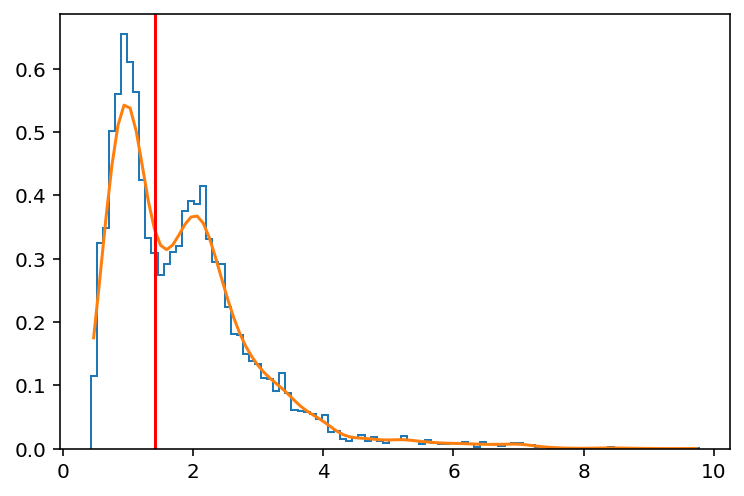

In [592]:
from scipy.stats import gaussian_kde
gkde = gaussian_kde(blurredWeights.flatten())
h,edges,_ = plt.hist(blurredWeights.flatten(),100,histtype="step",density=True);
bincenters = (edges[:-1]+edges[1:])/2
gkde_vals = gkde.evaluate(bincenters)
plt.plot(bincenters,gkde_vals)
th = bincenters[list(crawlDict(-gkde_vals.reshape(-1,1)+gkde_vals.max()+1,).keys())[1][0]-2]
# plt.hist(stdDimg.flatten(),50,histtype="step");
# th = 1.4#e[np.where(np.diff(np.diff(h)<0))[0][0]+1:][:2].mean()
plt.axvline(th,color="r")



In [593]:
testImage = blurredWeights[:,:]

In [601]:
B = crawlDict(testImage,th=th)

In [602]:
%matplotlib inline

In [603]:
dround = np.vstack([
    (-1,-1),
    (-1, 1),
    ( 1, 1),
    ( 1,-1),
    (-1,-1),
])
tmp = [(dx,dy) for dx,dy in dround]
# tmp += [tmp[0]]
dedges = []
for el in zip(tmp[:-1],tmp[1:]):
    el = np.array(el)+1
    el = np.vstack(sorted(el,key=np.linalg.norm))-1
#     dedges += [tuple(map(tuple,el*.5))]
    dedges += [el*.5]

dedges = np.stack(dedges)

In [604]:
toBreak = False
edgeID = OrderedDict()
for k in B:
    for x,y in B[k]:
        edges = dedges.copy()
        edges[...,0] += x
        edges[...,1] += y
        for edge in edges.reshape((-1,4)):
            edge = tuple(edge)
            if edge not in edgeID:
                edgeID[edge] = []
            edgeID[edge] += [k]
            if len(edgeID[edge])==2 and edgeID[edge][0]==edgeID[edge][1]:
                del edgeID[edge]
#         if len(nodeID[edge])==4:
#             if np.all([nodeID[node][j]==nodeID[node][0] for j in range(1,4)]):
#                 del nodeID[node]
# #                 print (nodeID[node])
# #                 toBreak = True
# #                 break
# #     if toBreak:
# #         break
#         toBreak = True
#         break
#     if toBreak: break
# if toBreak: break

In [605]:
invEdgeID = OrderedDict()
for k in edgeID:
    for p in edgeID[k]:
        if p not in invEdgeID:
            invEdgeID[p] = []
        invEdgeID[p] += [k]

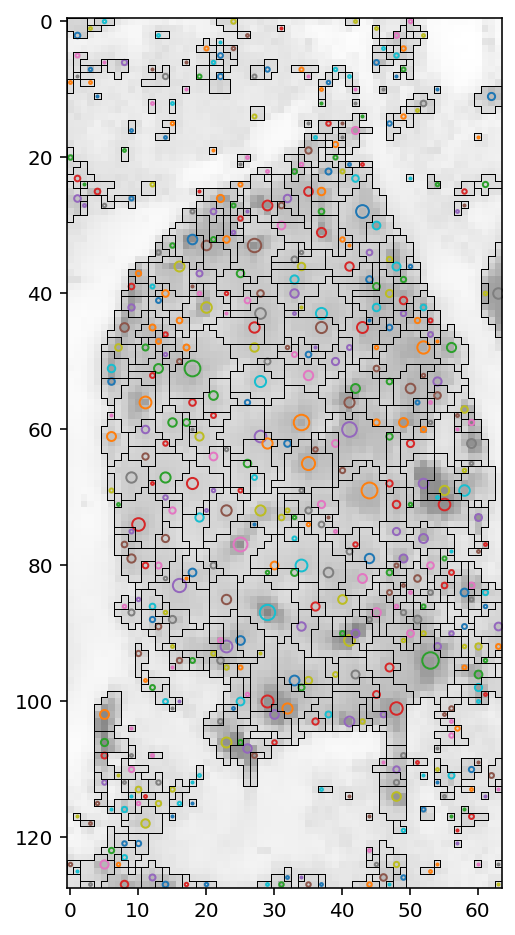

In [606]:
plt.figure(figsize=(7,8))
ax = plt.subplot(111)
ax.imshow(testImage.T,cmap="Greys",norm=LogNorm(),vmax=testImage.max()*10)

ks = list(B.keys())[::1]
for ik,k in enumerate(ks):
    c = plt.plot([])[0].get_color()
#     for el in B[k]:
#         plt.plot([el[0],k[0]],[el[1],k[1]],lw=.3,c=c)
#     for el in invEdgeID[k]:
#         x,y = np.array(el).reshape((2,2)).T
#         plt.plot(x,y,"k")
    x,y = k # np.mean(B[k],axis=0)
    plt.plot(x,y,"o",ms=1*len(B[k])**.5,mfc="none",c=c)
for el in np.unique(sum([invEdgeID[k] for k in ks],[]), axis=0):
    x,y = np.array(el).reshape((2,2)).T
    plt.plot(x,y,"k",lw=.5)
ax.set_aspect("equal")

### Similar with nodes (didn't lead anywhere)

In [651]:
toBreak = False
nodeID = OrderedDict()
for k in B:
    nodes = sum([[(x+dx,y+dy) for dx,dy in product([-.5,.5],[-.5,.5])] for x,y in B[k]],[])
    for node in nodes:
        if node not in nodeID:
            nodeID[node] = []
        nodeID[node] += [k]
        if len(nodeID[node])==4:
            if np.all([nodeID[node][j]==nodeID[node][0] for j in range(1,4)]):
                del nodeID[node]
#                 print (nodeID[node])
#                 toBreak = True
#                 break
#     if toBreak:
#         break

In [652]:
invNodeID = OrderedDict()
for k in nodeID:
    for p in nodeID[k]:
        if p not in invNodeID:
            invNodeID[p] = []
        invNodeID[p] += [k]

In [684]:
refvec = [0, 1]

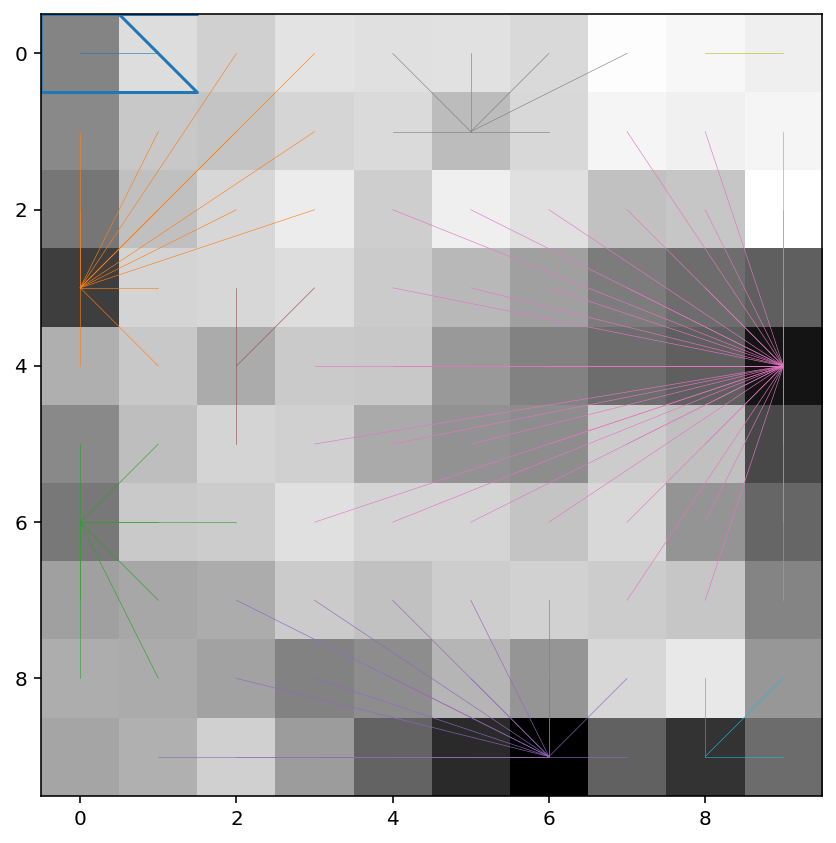

In [685]:
plt.figure(figsize=(7,8))
ax = plt.subplot(111)
ax.imshow(testImage.T,cmap="Greys",norm=LogNorm())
lim = plt.xlim(),plt.ylim()
ks = list(B.keys())
for ik,k in enumerate(ks[::1]):
    c = plt.plot([])[0].get_color()
    for el in B[k]:
        plt.plot([el[0],k[0]],[el[1],k[1]],lw=.3,c=c)
#     plt.plot(np.array(B[k]).T[0], np.array(B[k]).T[1],"s",c=c,alpha = 1,ms=15,mfc="none")
#     if ik>=0:
ax.set_aspect("equal")


for k in invNodeID:
#     x,y = np.vstack(invNodeID[k]).T
#     plt.plot(x,y,".")
    
    pts = np.vstack(invNodeID[k])
    origin = pts[np.argmin(np.linalg.norm(pts,axis=1))]

    # x,y = np.array(pts).T
    # plt.plot(x,y,".")
    x,y = np.array(sorted(pts, key=clockwiseangle_and_distance)+[origin]).T
    plt.plot(x,y,"-")
    break

In [701]:
pts = [[2,3], [5,2],[4,1],[3.5,1],[1,2],[2,1],[3,1],[3,3],[4,3]]

def clockwiseangle_and_distance(point):
    import math
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # I return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector

In [715]:
pts = np.vstack(invNodeID[k])
origin = pd.DataFrame(pts+.5).sort_values([0,1]).loc[0].values-.5

In [717]:
pts

[array([-0.5, -0.5]),
 array([-0.5,  0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([1.5, 0.5]),
 array([ 0.5, -0.5]),
 array([ 0.5, -0.5]),
 array([ 1.5, -0.5]),
 array([-0.5, -0.5])]

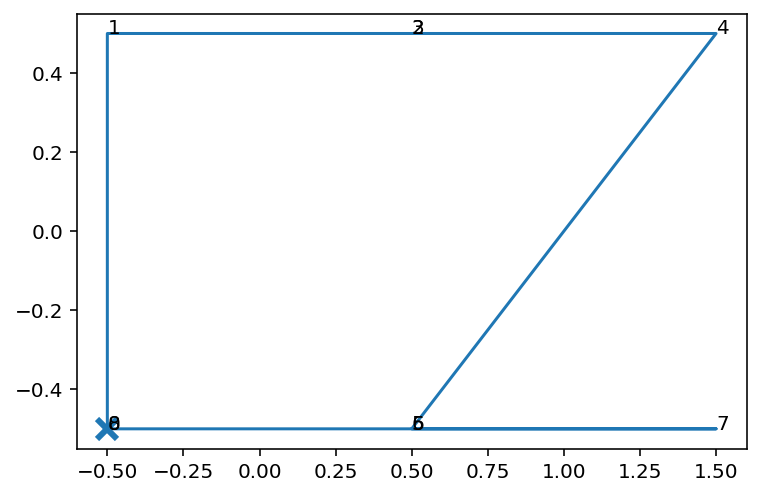

In [716]:
# origin = pts[np.argmin(np.linalg.norm(pts,axis=1))]
refvec = [0, 1]
# x,y = np.array(pts).T
# plt.plot(x,y,".")
pts = sorted(pts, key=clockwiseangle_and_distance)+[origin]
for j,(x,y) in enumerate(pts):
    plt.text(x,y,j)
x,y = np.array(pts).T
plt.plot(x,y,"-")
plt.plot(origin[0],origin[1],"C0x",ms=10,mew=3)

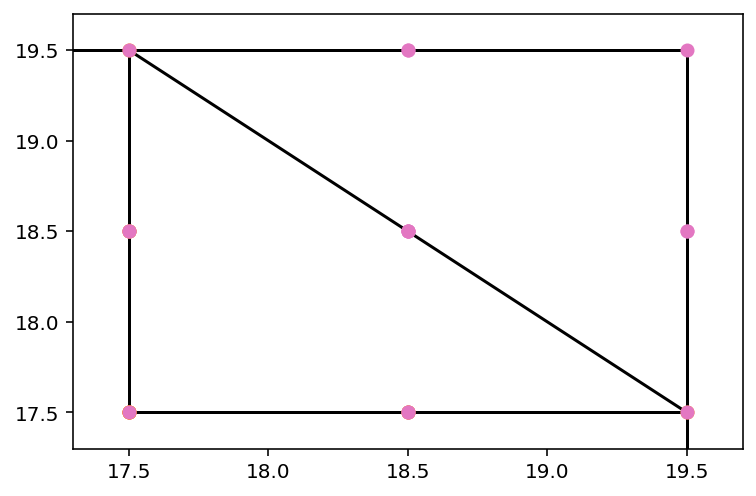

In [620]:
ax = plt.subplot()
for k in B:
    pts = np.vstack(sum([[(x+dx,y+dy) for dx,dy in product([-.5,.5],[-.5,.5])] for x,y in B[k]],[]))
    ch = ConvexHull(pts)
    x,y = pts.T
    convex_hull_plot_2d(ch,ax=ax)

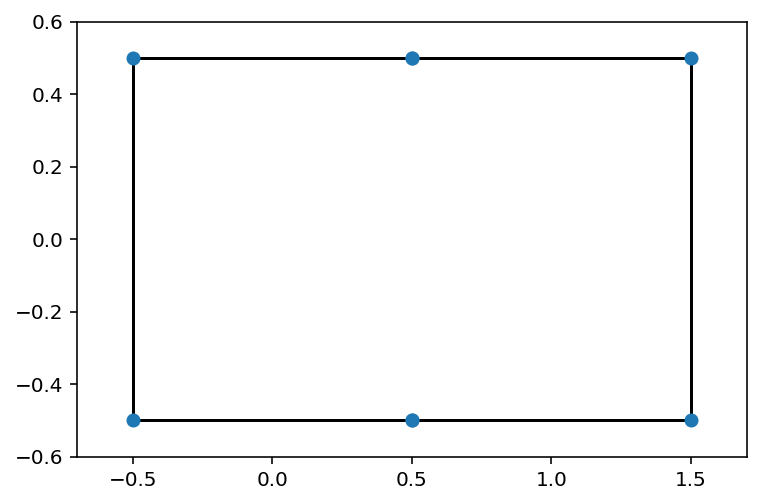

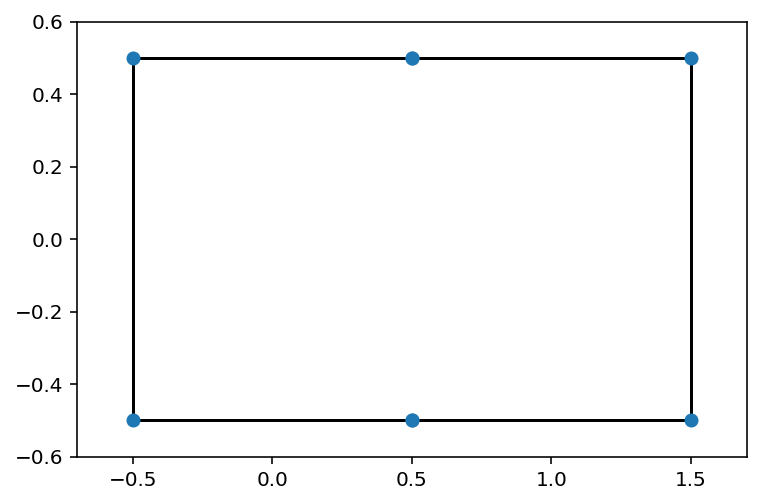

In [618]:

# for x,y in B[k]:
# for x,y in C.loc[C["size"].idxmax()].hood:

# ax.plot(x,y,".",mfc="grey",alpha = .3,ms=10)
convex_hull_plot_2d(ch,ax=ax)

In [566]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [ ]:
[(x,y) for x,y in C.loc[C["size"].idxmax()].hood]

In [569]:
ch = ConvexHull()

In [571]:

# (ch,)

### Define dataframe

In [607]:
C = pd.DataFrame([],index=np.arange(len(B)))
C["peak"] = B.keys()
C["pixels"] = B.values()
C["center"] = [np.mean(C.loc[i,"pixels"], axis=0) for i in C.index]
C["size"] = list(map(len,C["pixels"]))
cnt = Counter(C['size'])
cnt = OrderedDict([(k,cnt[k]) for k in sorted(cnt.keys())])
len(C)

509

<ErrorbarContainer object of 3 artists>

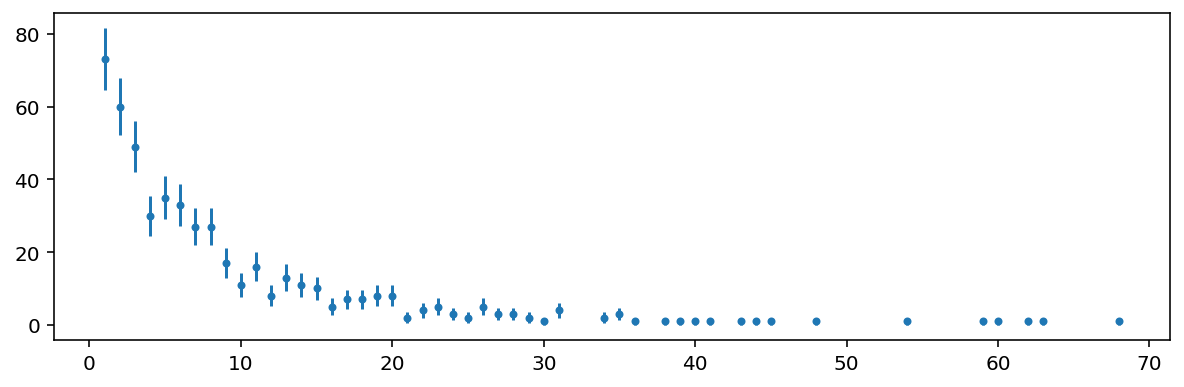

In [608]:
plt.figure(figsize=(10,3))
# plt.bar(cnt.keys(),cnt.values())
plt.errorbar(cnt.keys(),cnt.values(),np.array(list(cnt.values()))**.5,ls="none",marker=".")

In [609]:
from bidict import bidict

In [610]:
peak2idx = bidict([(peak,j) for j,peak in zip(C.index,C.peak)])

In [611]:
Cneighbors = [tuple([]) for i in C.index]

for edge in edgeID:
    if len(edgeID[edge])>1:
        for e1,e2 in [edgeID[edge],edgeID[edge][::-1]]:
            i = peak2idx[e1]
            j = peak2idx[e2]
            if j not in Cneighbors[i]:
                Cneighbors[i] += (j,)

In [612]:
C["neighbors"] = Cneighbors

In [613]:
toDrop = []#C[C.neighbors.apply(len)==0].query("size<4").index

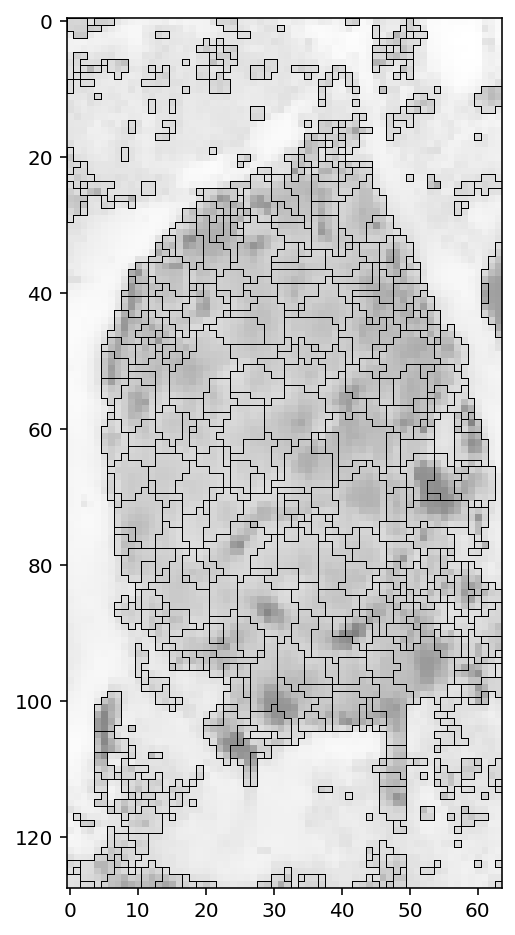

In [614]:
plt.figure(figsize=(7,8))
ax = plt.subplot(111)
ax.imshow(testImage.T,cmap="Greys",norm=LogNorm(),vmax=testImage.max()*10)

# for i in C.sort_values("size",ascending=False).index[:10]:
#     c = plt.plot([])[0].get_color()
#     x,y = np.mean(C.loc[i,"pixels"],axis=0)
#     plt.text(x,y,i)
for el in np.unique(sum([invEdgeID[k] for k in ks],[]), axis=0):
    x,y = np.array(el).reshape((2,2)).T
    plt.plot(x,y,"k",lw=.5)
    
for j in toDrop:
    for el in invEdgeID[peak2idx.inv[j]]:
        x,y = np.array(el).reshape((2,2)).T
        plt.plot(x,y,"C3",lw=.8)
ax.set_aspect("equal")

In [615]:
C = C.drop(index=toDrop)

In [616]:
C["trace"] = [m_orig[:,
    [el[0] for el in C.loc[i,"pixels"]],
    [el[1] for el in C.loc[i,"pixels"]]
       ].mean(axis=1) for i in C.index]

In [617]:
(C["size"]>10).sum()

147

In [618]:
# Correlations = OrderedDict()

# for i in C.index:
#     for j in C["neighbors"][i]:
#         if j>i: continue
# #         Correlations[(i,j)] = np.corrcoef(C.loc[i,"trace"],C.loc[j,"trace"])[0,1]
#         Correlations[(i,j)] = np.corrcoef(np.diff(C.loc[i,"trace"]),
#                                           np.diff(C.loc[j,"trace"]))[0,1]

# # plt.hist(Correlations.values(),100);

# x = np.array(list(Correlations.values()))
# plt.hist(x,200,log=True,density=True);
# plt.axvline(lw=.5,color="grey")
# ss = median_absolute_deviation(x)
# mm = np.median(x)
# xr = np.linspace(-3*ss,3*ss)+mm
# plt.plot(xr, dst.norm.pdf(xr,scale=ss,loc=mm))

In [362]:
from scipy.stats import median_absolute_deviation

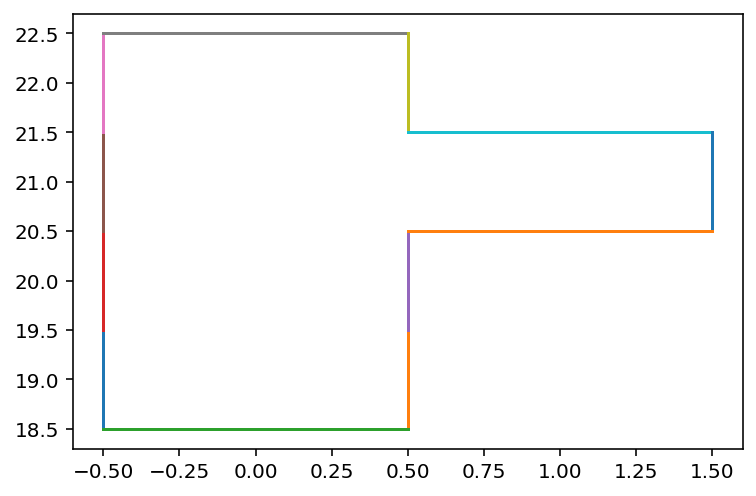

In [619]:
i = 2#C.sort_values("size").index[0]
peak = C.loc[i,"peak"]
x = [tuple(map(tuple,np.array(el).reshape((2,2)))) for el in invEdgeID[peak]]

for el in x:
    el = np.transpose(el)
    plt.plot(*el)

# nodes = np.unique(np.vstack(x),axis=0)

nodes = list(x[0])

for i in range(len(x)-2):
    nexts = [edge for edge in x if (edge[0]==nodes[-1] or edge[1]==nodes[-1])]
    for cand in np.unique(sum(nexts,()),axis=0):
        if tuple(cand) not in nodes:
            nodes += [tuple(cand)]
            break
#     assert len(nexts)==1
#     nextEdge = nexts[0]
#     if nextEdge[0]==nodes[-1]:
#         nodes += [nextEdge[1]]
#     elif nextEdge[1]==nodes[-1]:
#         nodes += [nextEdge[0]]
#     else:
#         raise ValueError()
#     break
#     if len(nexts)==1:
#         nodes += [nexts[0][1]]
#     elif len(nexts)<0:
#         nexts = [edge for edge in x if edge[1]==nodes[-1]]
#         assert len(nexts)==1
#         nodes += [nexts[0][0]]
#     else:
#         assert len(nexts)==1

In [620]:
x,y = np.vstack(nodes+[nodes[0]]).T

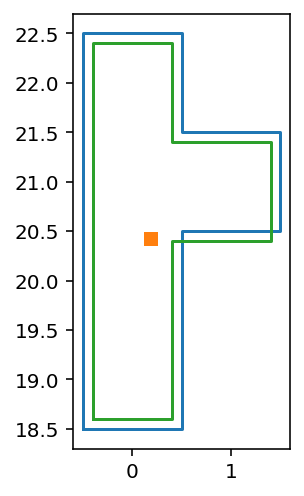

In [628]:
plt.plot(x,y)
plt.plot(np.mean(x),y.mean(),"s")
plt.plot(x-.1*np.sign(x-x.mean()),y-.1*np.sign(y-y.mean()))
plt.gca().set_aspect("equal")

array([-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.])

In [573]:
len(x),len(nodes)

(10, 7)

In [558]:
edge, tuple(nodes[-2:])

((62.5, 126.5, 63.5, 126.5), (52.5, 2.5))

In [553]:
nexts

[((51.5, 2.5), (52.5, 2.5))]

In [554]:
nodes

[(51.5, 1.5), (51.5, 2.5)]

In [ ]:
start = nodes[0]

In [ ]:
next_ = np.where([for ])

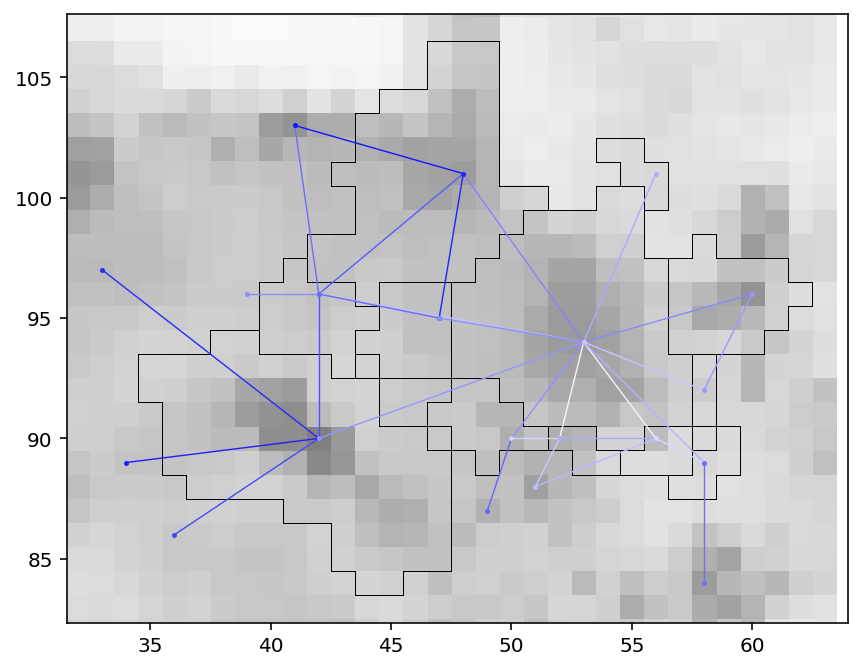

In [349]:
plt.figure(figsize=(7,8))
ax = plt.subplot(111)
iis = C.sort_values("size",ascending=False).index[:1]
iis = np.unique(sum(C.loc[iis,"neighbors"],tuple(iis)))

for el in np.unique(sum([invEdgeID[peak] for peak in C.loc[iis,"peak"]],[]), axis=0):
    x,y = np.array(el).reshape((2,2)).T
    plt.plot(x,y,"k",lw=.5)

for i in iis:
#     c = plt.plot([])[0].get_color()
#     x,y = C.loc[i,"peak"]
    for j in C.loc[i,"neighbors"]:
        if j>i: continue
        plt.plot(*np.vstack(C.loc[[i,j],"peak"].values).T,c=plt.cm.bwr_r(Correlations[(i,j)]/2+.5),lw=.7,marker=".",ms=3)
xl,yl = plt.xlim(), plt.ylim()
ax.imshow(testImage.T,cmap="Greys",norm=LogNorm(),vmax=testImage.max()*10)
plt.xlim(xl)
plt.ylim(yl)
ax.set_aspect("equal")

### examine by eye some correlations

In [164]:
breakout = False
for i in C.loc[i+1:].index:
    for j in C["neighbors"][i]:
        if j>i: continue
    #     break
        cc = np.corrcoef(C.loc[i,"trace"],C.loc[j,"trace"])[0,1]
        if cc>.4:
            print ("found")
            breakout=True
            break
    if breakout: break

found


In [165]:
cc

0.879294432161259

In [398]:
ii,jj = (161, 129)

In [399]:
C.loc[[ii,jj]]

peak                                             pixels  \
161  (30, 102)  [(27, 103), (27, 104), (28, 102), (28, 103), (...   
129  (23, 106)  [(20, 103), (20, 104), (20, 105), (21, 102), (...   

                                       center  size  \
161  [30.307692307692307, 103.38461538461539]    26   
129   [22.636363636363637, 104.3030303030303]    33   

                          neighbors  \
161  (129, 141, 160, 168, 178, 191)   
129                 (140, 141, 161)   

                                                 trace  
161  [10.307692307692308, 10.346153846153847, 10.34...  
129  [13.757575757575758, 15.0, 14.333333333333334,...

In [385]:
%matplotlib notebook

<IPython.core.display.Javascript object>


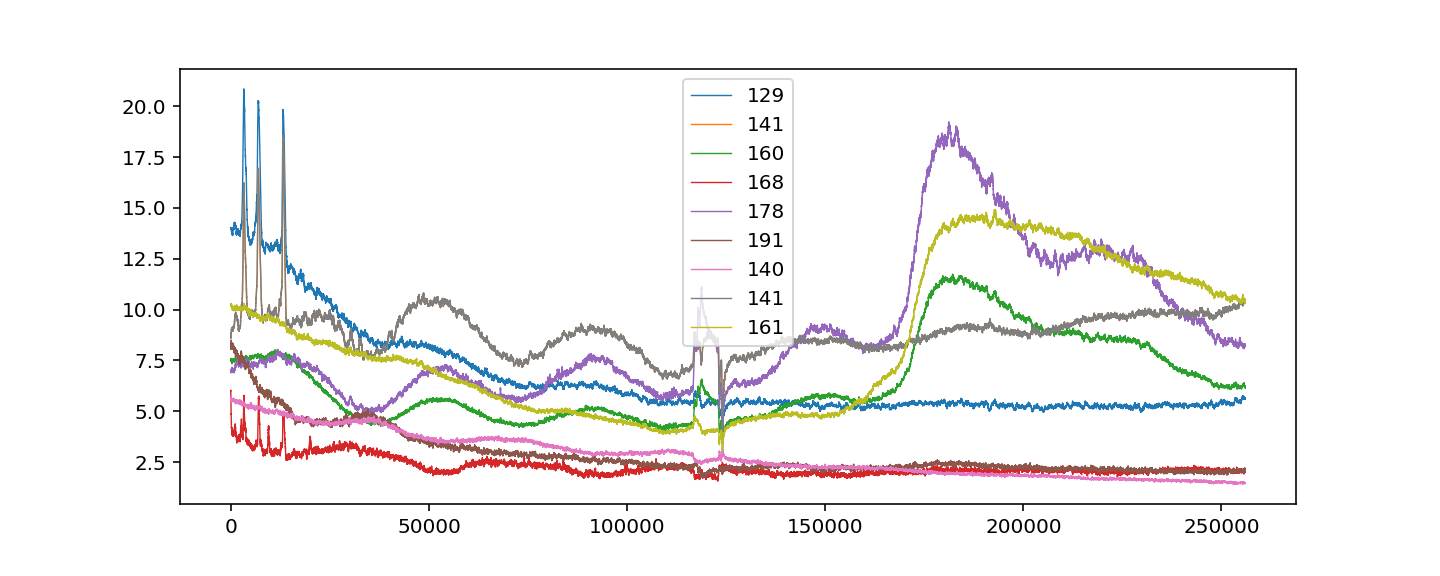

In [405]:
n = 101
plt.figure(figsize=(10,4))
for i in sum(C.loc[[ii,jj],"neighbors"],()):
# for i in [ii,jj]:
    plt.plot(runningAverage(C.loc[i,"trace"],n),lw=.7,label=i)
# plt.plot(runningAverage(C.loc[jj,"trace"],n),lw=.7)
plt.legend()

<IPython.core.display.Javascript object>


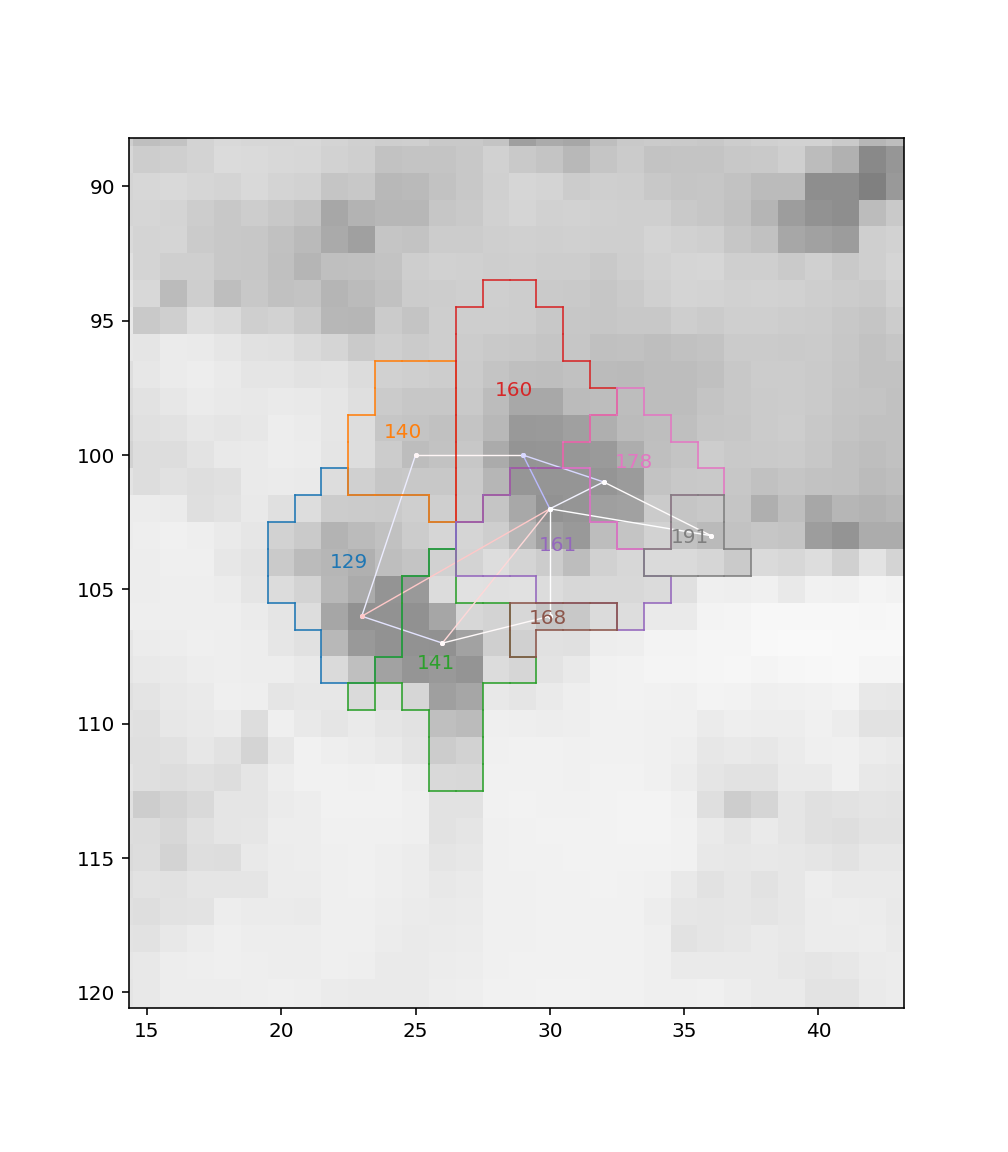

In [404]:
plt.figure(figsize=(7,8))
ax = plt.subplot(111)
ax.imshow(testImage.T,cmap="Greys",norm=LogNorm(),vmax=testImage.max()*10)

# for i in C.sort_values("size",ascending=False).index[:10]:
#     c = plt.plot([])[0].get_color()
#     x,y = np.mean(C.loc[i,"pixels"],axis=0)
#     plt.text(x,y,i)
# for el in np.unique(sum([invEdgeID[k] for k in ks],[]), axis=0):
#     x,y = np.array(el).reshape((2,2)).T
#     plt.plot(x,y,"k",lw=.5)
    
iis = np.unique(sum(C.loc[[ii,jj],"neighbors"],()))
for j in iis:
    c=plt.plot([])[0].get_color()
    for el in invEdgeID[peak2idx.inv[j]]:
        x,y = np.array(el).reshape((2,2)).T
        plt.plot(x,y,lw=.8,c=c)
    x,y = np.mean(invEdgeID[peak2idx.inv[j]],axis=0)[:2]
    plt.text(x,y,j,color=c,va="center",ha="center")
    for i in iis:
        if (i,j) not in Correlations: continue
        plt.plot(*np.vstack(C.loc[[i,j],"peak"].values).T,c=plt.cm.bwr_r(Correlations[(i,j)]/2+.5),lw=.7,marker=".",ms=3)
ax.set_aspect("equal")

In [468]:
%matplotlib inline

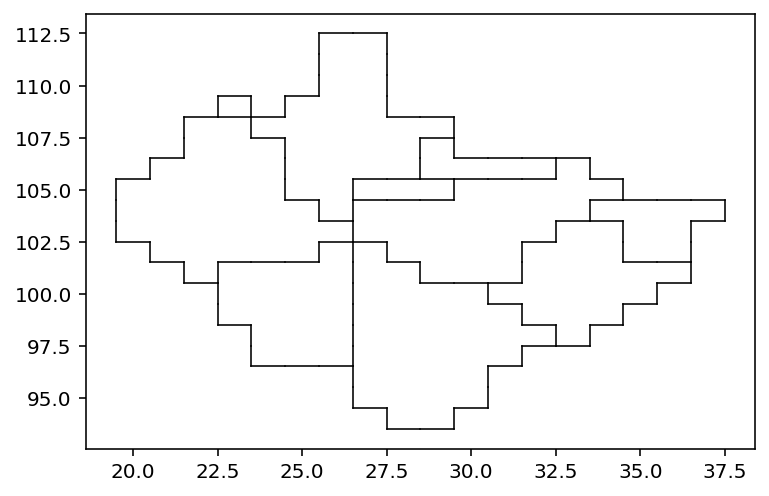

In [179]:
from matplotlib import animation, rc

array([  8.5625, 110.0625])

In [185]:
%matplotlib inline

In [220]:
# showMovies(movies_,fps = 30):
#     from matplotlib import animation
#     fig, ax = plt.subplots(1,len(movies_),figsi)

In [265]:
m_orig.shape

(256000, 64, 128)

In [287]:
subset = (slice(0,None),slice(0,None))
showMovie = rebin(m_orig[(slice(None),)+subset],100)

<IPython.core.display.Javascript object>


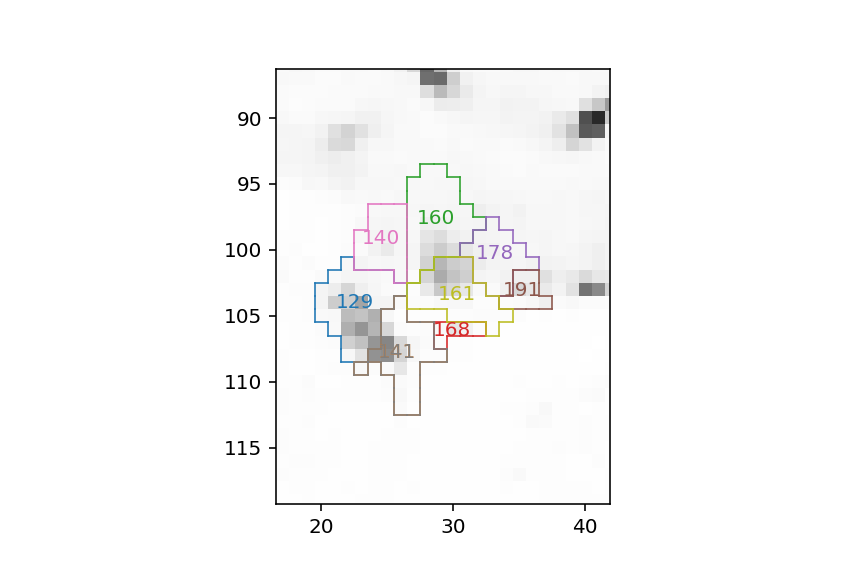

In [448]:
fig, ax = plt.subplots()
im = ax.imshow(showMovie[0].T, cmap="Greys", vmin=0, vmax=showMovie.max())
for j in sum(C.loc[[ii,jj],"neighbors"],()):
    c=plt.plot([])[0].get_color()
    for el in invEdgeID[peak2idx.inv[j]]:
        x,y = np.array(el).reshape((2,2)).T
        x -= subset[0].start
        y -= subset[1].start
        plt.plot(x,y,lw=.8,c=c)
    x,y = np.mean(invEdgeID[peak2idx.inv[j]],axis=0)[:2]
    x -= subset[0].start
    y -= subset[1].start
    plt.text(x,y,j,color=c,va="center",ha="center")
# line, = ax.plot([], [], lw=2)

In [290]:
def init():
    im.set_data(showMovie[0].T)
    return (im,)
def animate(i):
    im.set_data(showMovie[i].T)
    return (im,)

In [293]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(showMovie)//10,
                               interval=30,
                               blit=True
                              )

In [294]:
from IPython.display import HTML

In [301]:
# HTML(anim.to_jshtml(fps=30))

In [630]:
# %%time
# HTML(anim.to_html5_video())

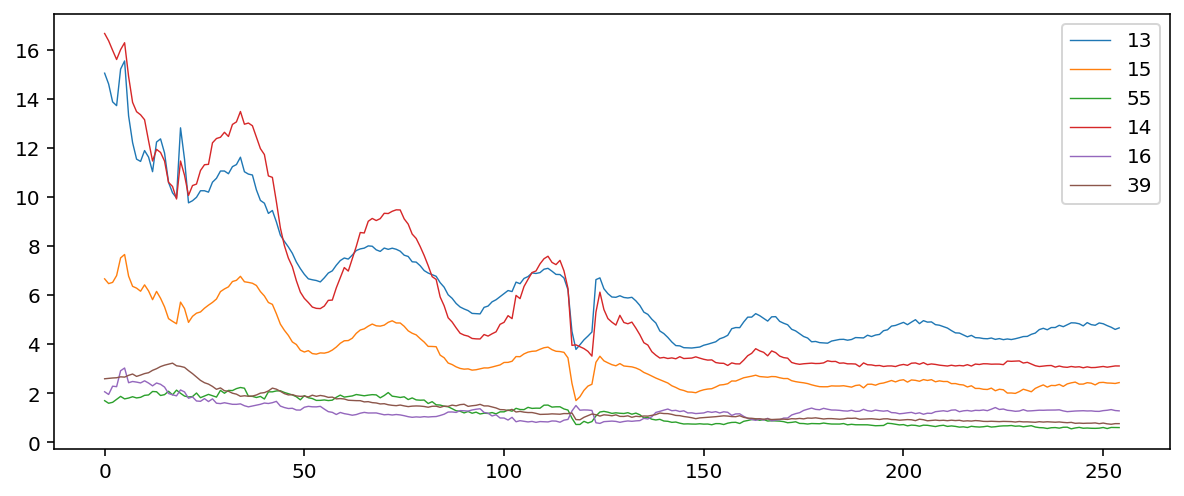

In [261]:
n = 1001
plt.figure(figsize=(10,4))
for i in sum(C.loc[[ii,jj],"neighbors"],()):
    plt.plot(rebin(C.loc[i,"trace"],n),lw=.7,label=i)
# plt.plot(runningAverage(C.loc[jj,"trace"],n),lw=.7)
plt.legend()

In [415]:
import plotly.graph_objects as go

In [417]:
# fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
# fig.show()


In [418]:
import plotly.express as px

In [419]:
df = px.data.gapminder().query("continent=='Oceania'")

In [424]:
len(time), len(C.loc[ii,"trace"])

(256000, 256000)

In [452]:
n = 10
df = []
for i in np.unique(sum(C.loc[[ii,jj],"neighbors"],())):
    x = rebin(C.loc[i,"trace"],n)
    df += [pd.DataFrame(OrderedDict([
        ("intensity", x),
        ("time [s]", np.linspace(0,time.max(),len(x)))
    ]))]
    df[-1]["roi"] = i

df = pd.concat(df)

In [453]:
fig = px.line(df, x="time [s]", y="intensity", color='roi',hover_data=["roi"])

In [40]:
# fig.show()

In [480]:
x,y

(array([37.5, 37.5]), array([103.5, 104.5]))

In [486]:
img = saveRes["dOrig_std"]
fig = px.imshow(img.T, color_continuous_scale='gray_r')
for el in np.unique([el for j in iis for el in invEdgeID[peak2idx.inv[j]]], axis=0):
    x,y = np.array(el).reshape((2,2)).T
#     plt.plot(x,y,"k",lw=.8)
    fig.add_trace(go.Scatter(x=x,y=y,mode="lines"))
# fig.add_trace(go.Contour(z=img, showscale=False,
#                          contours=dict(start=0, end=7, size=7, coloring='lines'),
#                          line_width=2))

In [41]:
# fig.show()

In [457]:
from plotly.subplots import make_subplots

In [459]:
make_subplots?

In [42]:
# fig = make_subplots(1, 2, column_widths=(.3,.7),)
# fig.add_trace(go.Image(z=), 1, 1)
# fig.show()

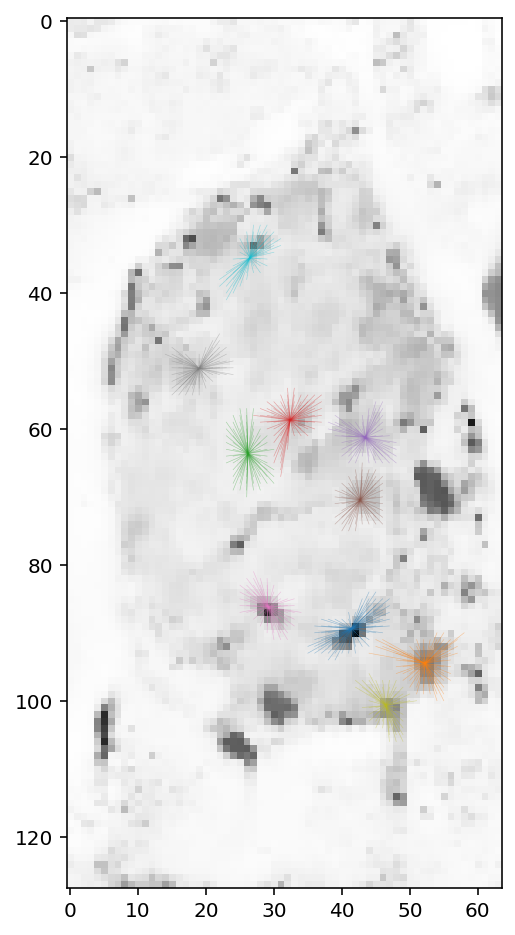

In [147]:
plt.figure(figsize=(7,8))
ax = plt.subplot(111)
ax.imshow(blurredWeights.T,cmap="Greys",
#           norm=LogNorm()
         )

# for j in C.query("50<size<100").index:
for j in C.sort_values("size",ascending=False).index[:10]:
    c = plt.plot([])[0].get_color()
    # k = C.loc[j,"center"]
    k = np.mean(C.loc[j,"pixels"], axis=0)
    for el in C.loc[j,"pixels"]:
        plt.plot([el[0],k[0]],[el[1],k[1]],lw=.3,c=c,alpha = .4)
ax.set_aspect("equal")

In [74]:
C.loc[i,"pixels"]

[(61, 39), (61, 40), (61, 41)]

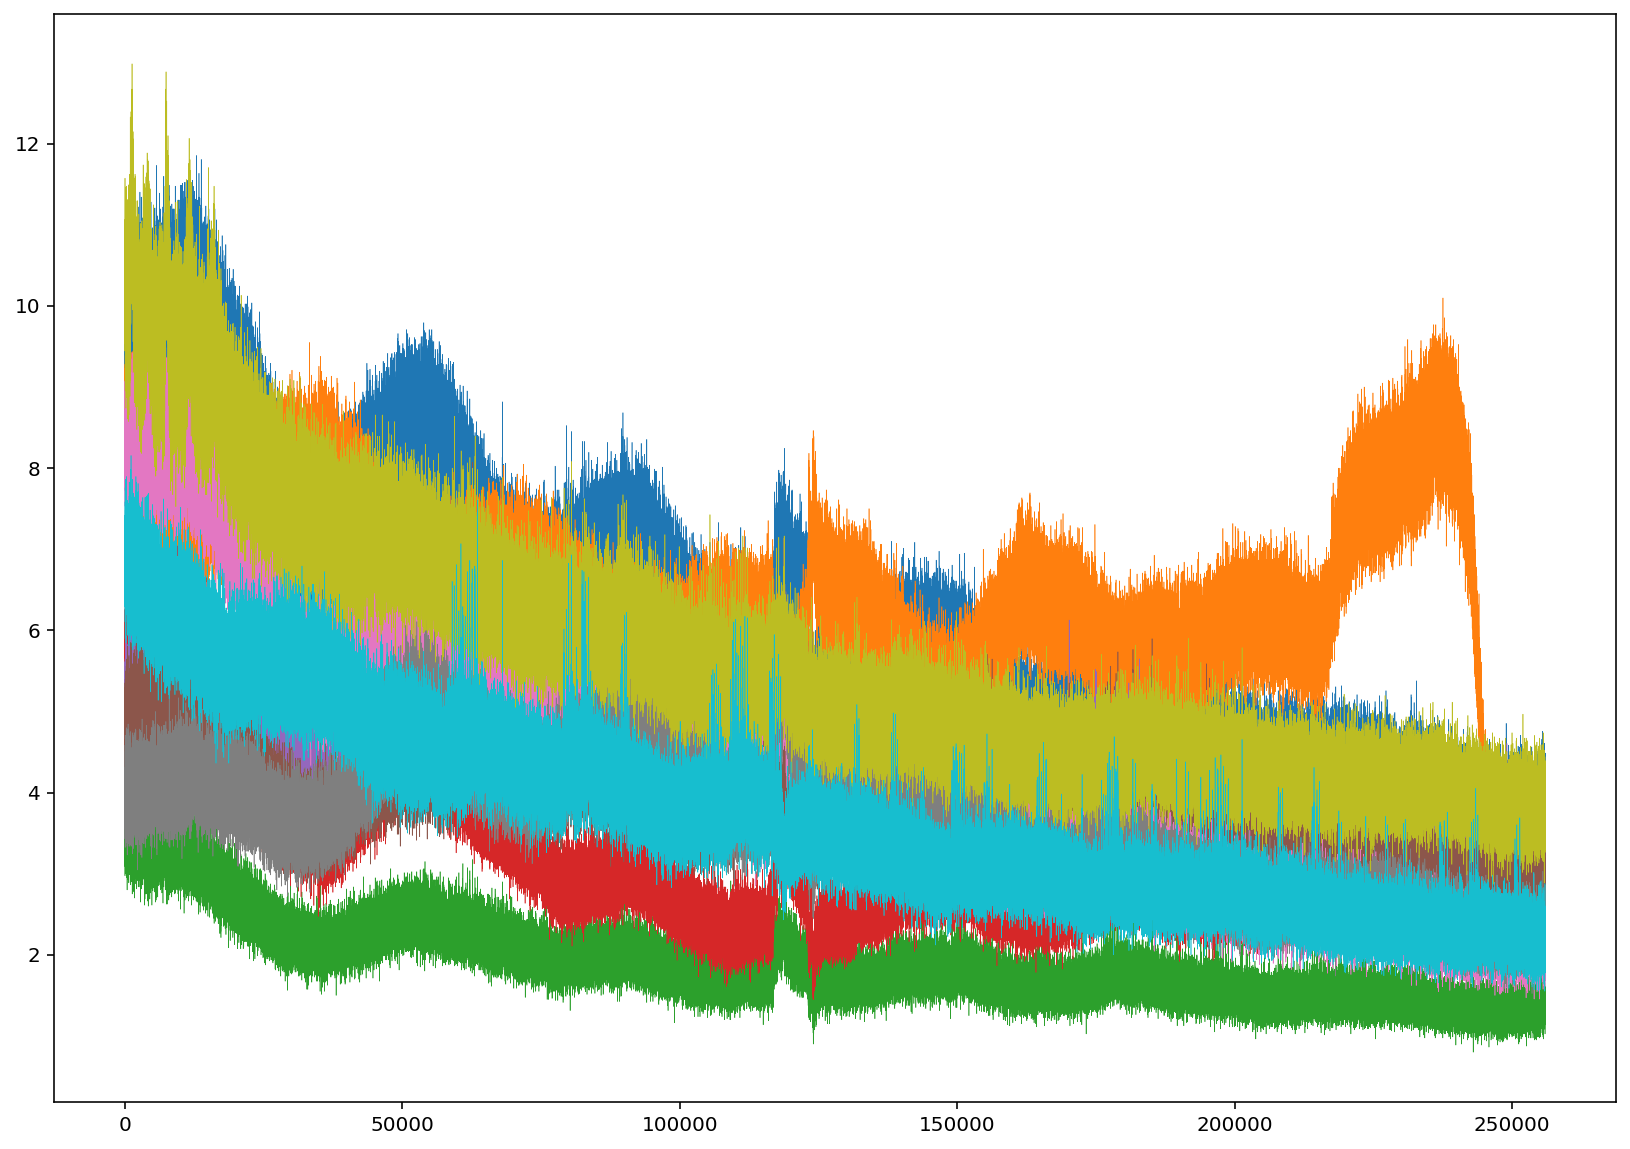

In [76]:
plt.figure(figsize=(14,10))
for i in C.sort_values("size",ascending=False).index[:10]:
    x = C.loc[i,"trace"]
    plt.plot(x,lw=.3)

In [77]:
# roiCenters = np.vstack([np.mean(hood,axis=0)  for hood in C.sort_values("size",ascending=False).hood[:10]]).T[::-1]

### Filter (detrend) ROIs

In [69]:
from numba import jit, prange

In [70]:
@jit 
def percFilter(x_,perc,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
        out[i] = np.percentile(x_[i:i+filterSize],perc)
    return out
@jit 
def runningAverage(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
        out[i] = np.nanmean(x_[i:i+filterSize])
    return out
@jit 
def runningStd(x_,filterSize):
    if filterSize%2==0:
        raise ValueError("filter size needs to be odd number")
    delta = filterSize//2
    out = np.zeros_like(x_)
    x_ = np.hstack((x_[:delta][::-1], x_, x_[-delta:][::-1]))
    for i in prange(len(out)):
        out[i] = np.nanstd(x_[i:i+filterSize])
    return out


In [95]:
# dt = .333
ironScale = 2.
wIron = int(ironScale*m_orig.fr)
if wIron%2==0:
    wIron += 1
print(wIron)
filterPars = (wIron,wIron,20.,2)

49


In [72]:
# tmp = np.array(C["trace"][0],)#dtype=np.float32)
# tmp.dtype

In [73]:
# %%timeit
# percFilter(tmp[:10000],np.float32(10),np.int32(101))

In [74]:
# %%timeit
# percFilter(tmp[:10000],10.,101)

In [75]:
%%capture
lowPass(C["trace"][0],*filterPars)

In [134]:
%matplotlib notebook

In [81]:
time = np.arange(len(m_orig))/m_orig.fr

<IPython.core.display.Javascript object>


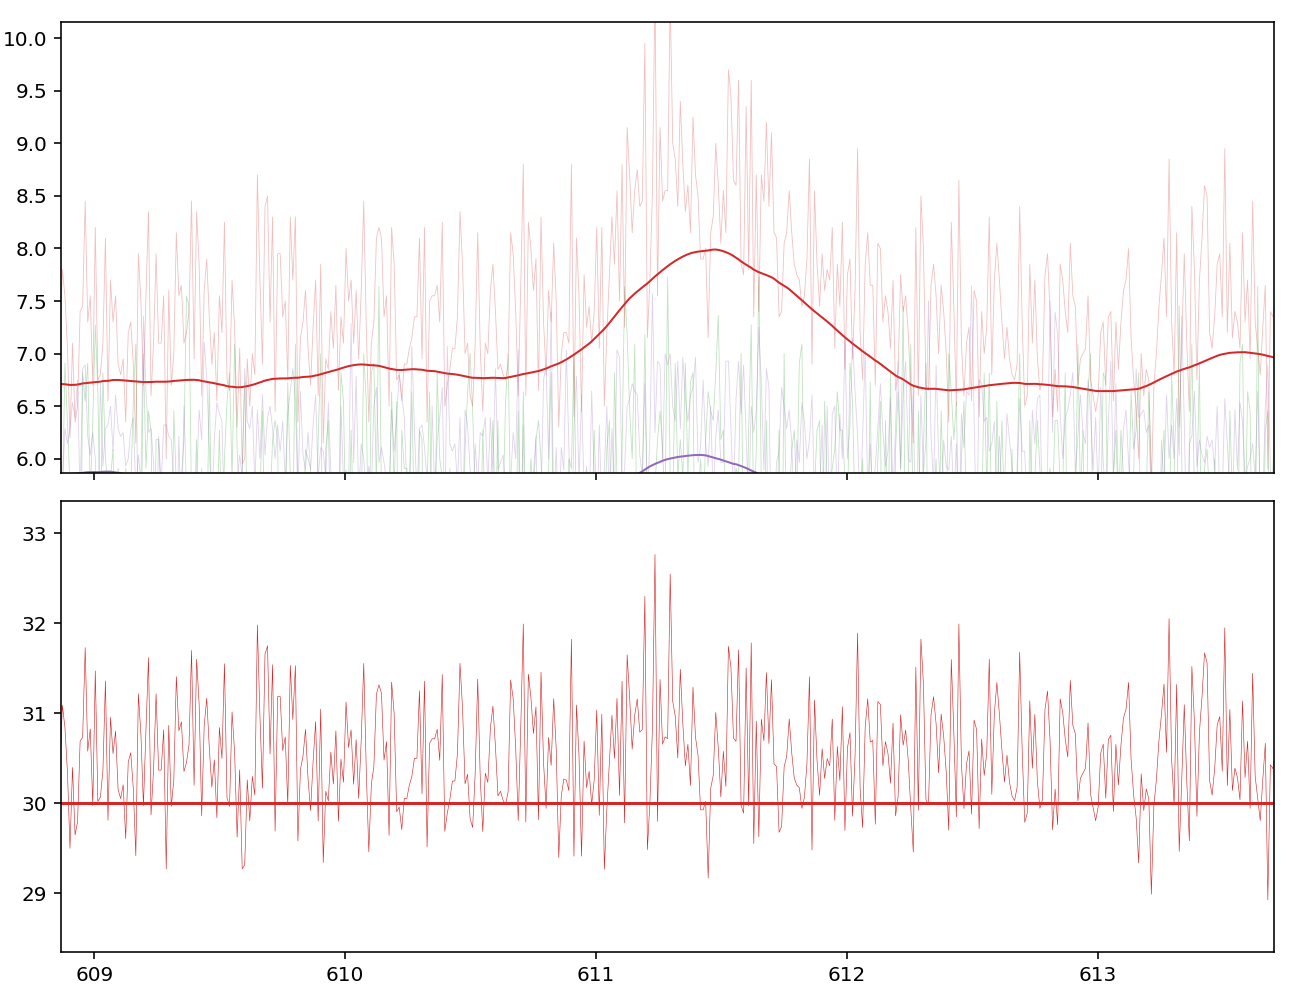

In [135]:
# %%capture
plt.close()
fig, axs = plt.subplots(2,1,figsize=(9,7), sharex=True)
ia = 0
n = 3
for i in range(10):
    np.random.seed(i)
    roi = np.random.choice(C.query("size>10").index)
    x = C.loc[roi,"trace"]
    c = "C%i"%ia
    axs[0].plot(time,x,c=c,lw=.4,alpha = .3)
    xf = lowPass(x,*filterPars)
    axs[0].plot(time,xf,label=roi,c=c,lw=1)
    yoffset = 10*ia
    axs[1].plot(time,x-xf+yoffset,label=roi,c=c,lw=.3)
    axs[1].axhline(yoffset,color=c)
    ia += 1
fig.tight_layout()

In [86]:
metadata

T          256000
X             128
Y              64
freq      99.0535
pxSize    2.09988
pxUnit         µm
Name: 0, dtype: object

In [121]:
from general_functions import multi_map

In [281]:
def iterf(x_):
    return lowPass(x_,*filterPars)

In [ ]:
C["slower_%g"%ironScale] = multi_map(iterf,C.loc[:,"trace"].values,processes=10)

In [ ]:
C["faster_%g"%ironScale] = [C.loc[i,"trace"] - C.loc[i,"slower_%g"%ironScale] for i in C.index]

In [135]:
%matplotlib inline

CPU times: user 186 ms, sys: 12 ms, total: 198 ms
Wall time: 197 ms


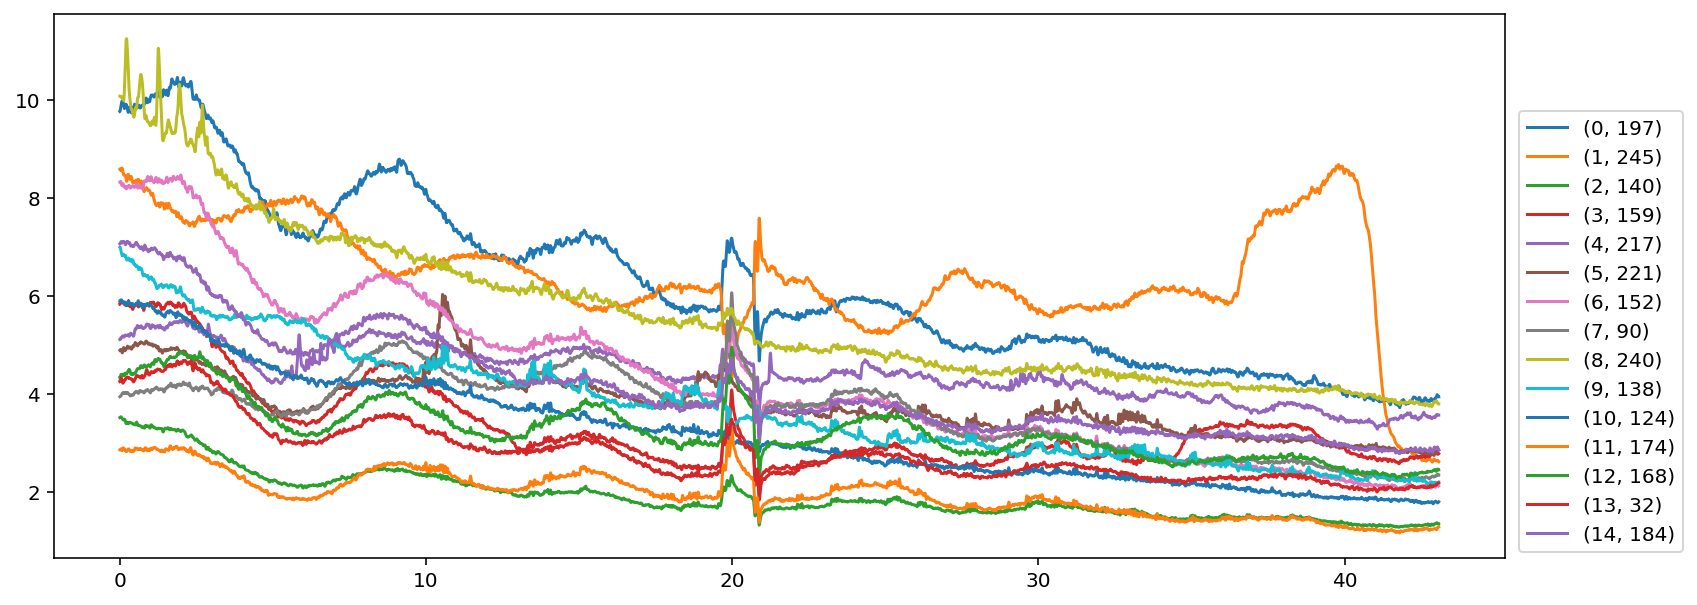

In [285]:
%%time
plt.figure(figsize=(13,5))
for i,j in enumerate(C.sort_values("size",ascending=False).index[:15]):
    x = C.loc[j,"slower_2.5"].copy()
#     x = x/x.mean()
    plt.plot(time/60, x,label=(i,j))
#     plt.plot(time[:-1]/60,np.diff(x))
plt.legend(loc=(1.01,.01))

In [181]:
%matplotlib notebook

In [195]:
from scipy.stats import distributions as dst

<IPython.core.display.Javascript object>


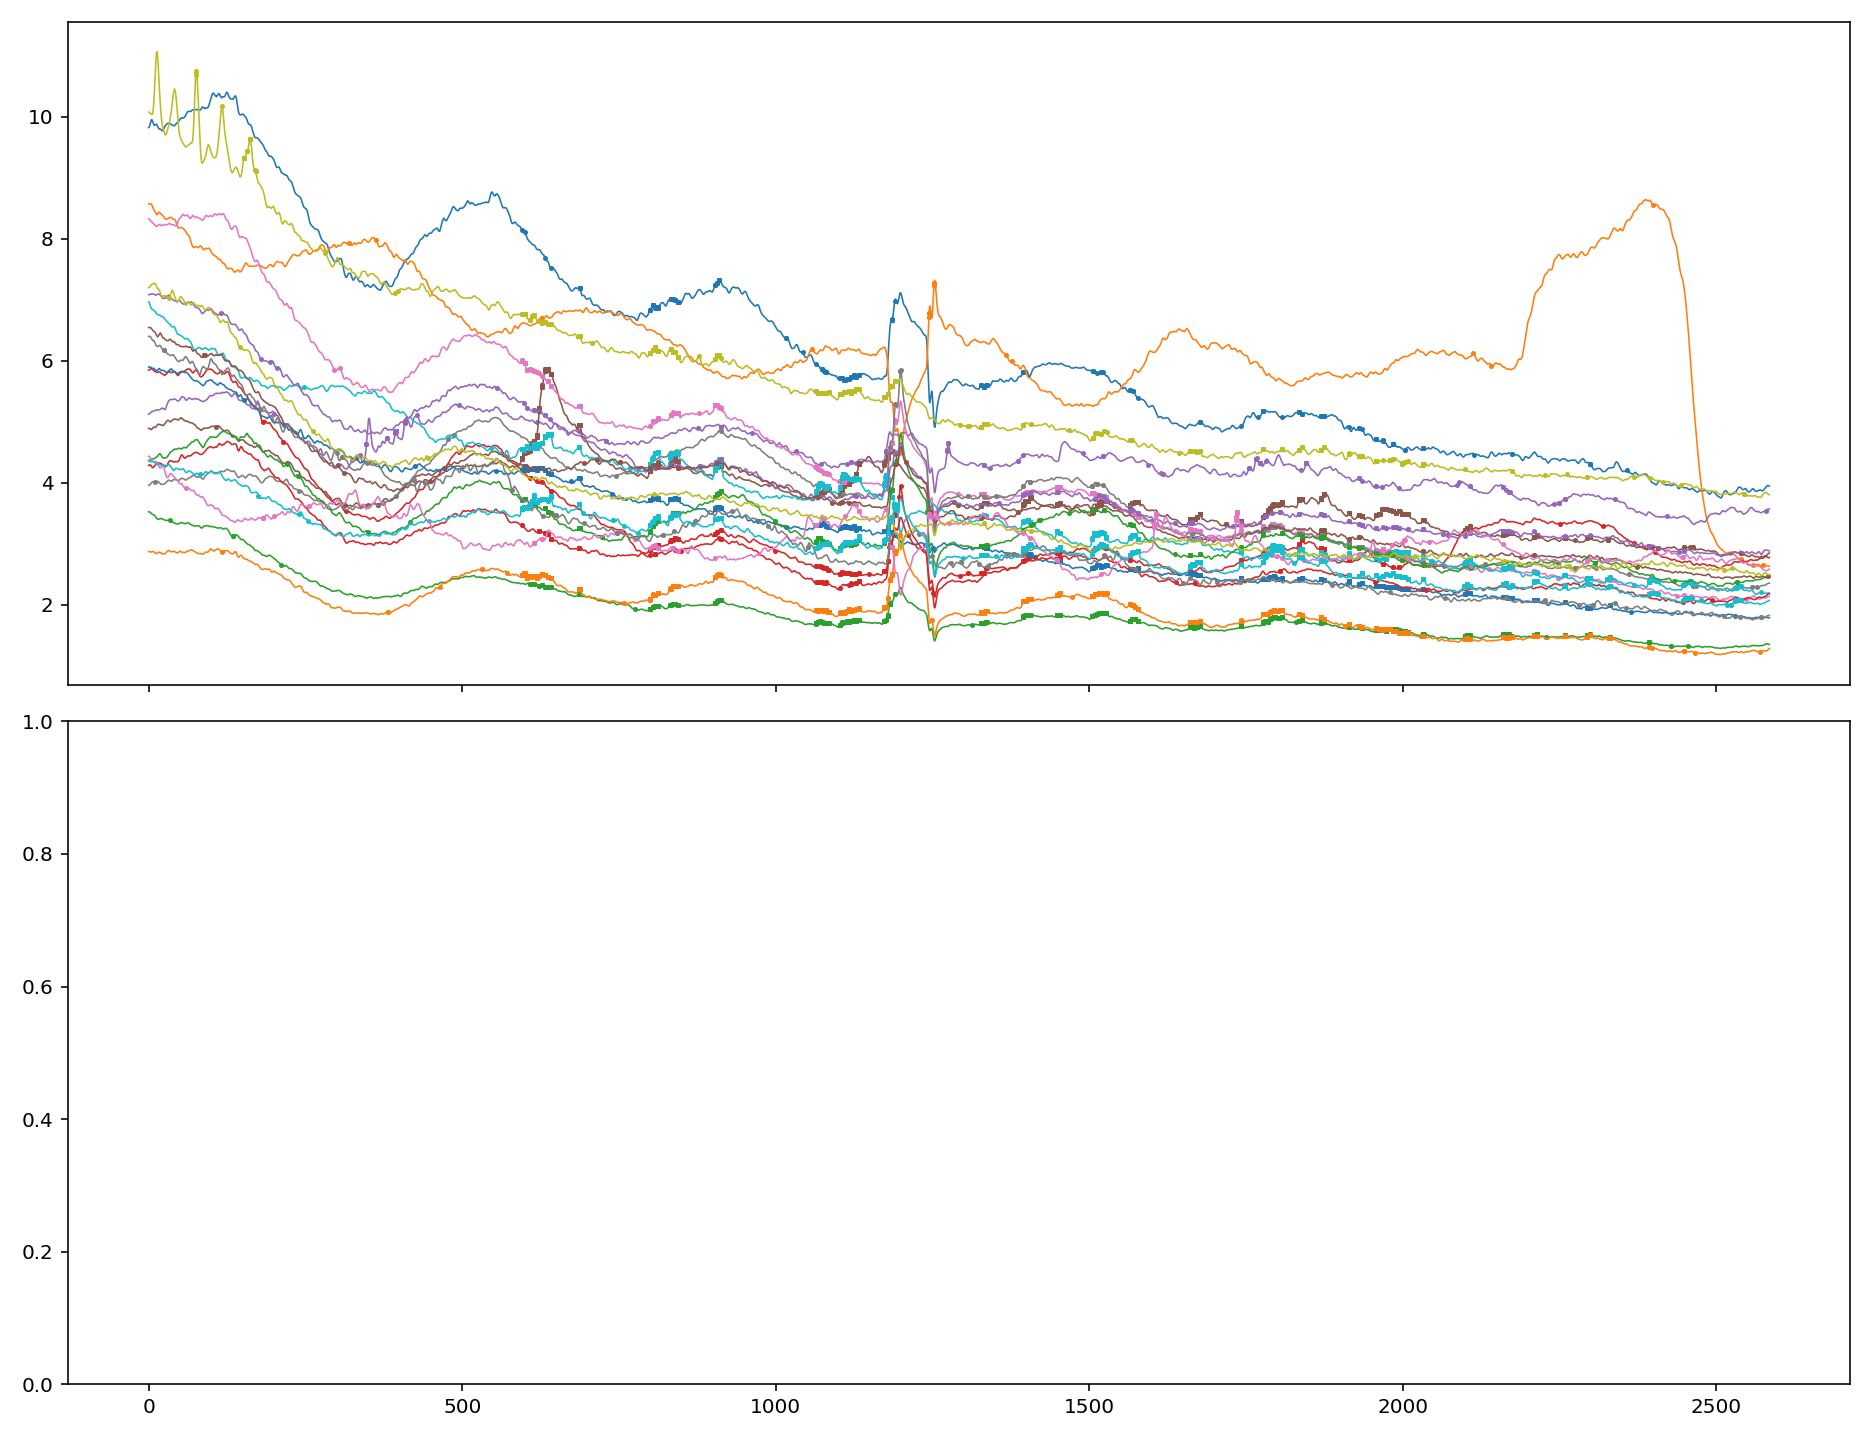

CPU times: user 22.6 s, sys: 9.28 ms, total: 22.6 s
Wall time: 22.6 s


In [228]:
%%time
fig, axs = plt.subplots(2,1,figsize=(13,10), sharex=True)
ia = 0
# for i in [0,1,3,4,5,9]:
for i in range(20):
    j = C.sort_values("size",ascending=False).index[i]
    c = "C%i"%i
    xs = C.loc[j,"slower_4"].copy()
    xfoffset = ia*2
    xf = C.loc[j,"faster_4"].copy() 
    
    axs[0].plot(time, xs,c=c,lw=.8)
    
    n = 5
    xfa = runningAverage(xf,n)
    xfastd = -percFilter(xfa[::n],15.8,wIron*3)
    xfastd = np.repeat(xfastd,n)
#     axs[1].plot(time, xfa+ xfoffset,c=c,lw=.5,alpha = .7)
    ns = 4
#     axs[1].plot(time, xfoffset + ns*xfastd,c=c,lw=.5,alpha = .7)
#     axs[1].plot(time, xfoffset - ns*xfastd,c=c,lw=.5,alpha = .7)
    flt = xfa>ns*xfastd
    axs[0].plot(time[flt], xs[flt],".",c=c, ms=3)
    ia += 1
#     if ia>=2: break
# axs[-1].set_xlim(400,1100)
fig.tight_layout()

In [253]:
xsf = decayfit(xs)

<IPython.core.display.Javascript object>


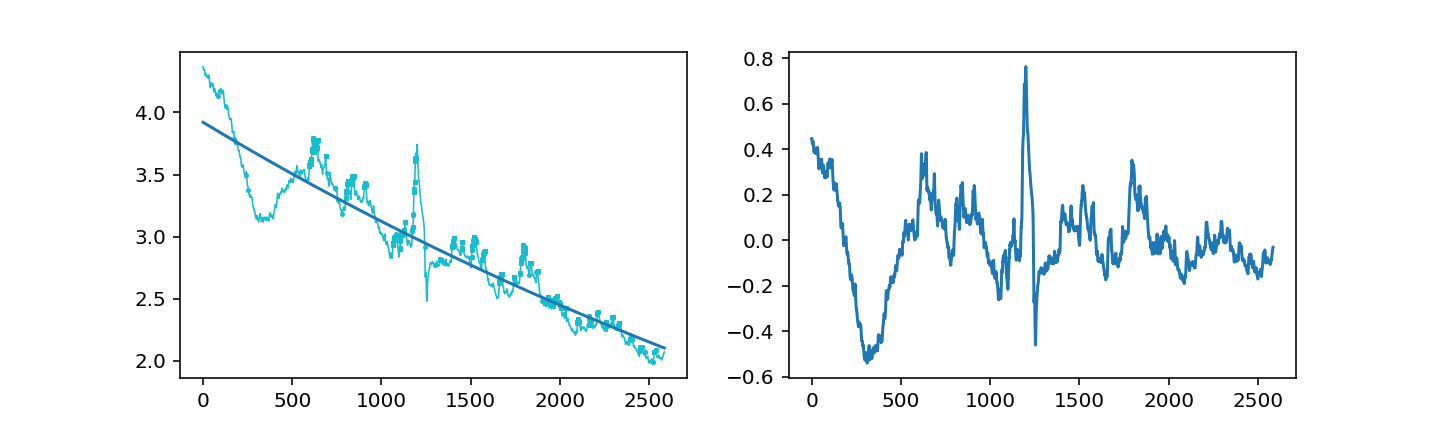

In [255]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(time, xs,c=c,lw=.8)
plt.plot(time[flt], xs[flt],".",c=c, ms=3)
# k = np.mean(np.diff(xs)/np.diff(time))
# n = np.mean(xs-k*time)
# plt.plot(time, k*time+n)
plt.plot(time, xsf)
# plt.xlim(100,1100)

plt.subplot(122)
plt.plot(time, xs-xsf)

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


CPU times: user 1min 35s, sys: 17.3 ms, total: 1min 35s
Wall time: 1min 35s


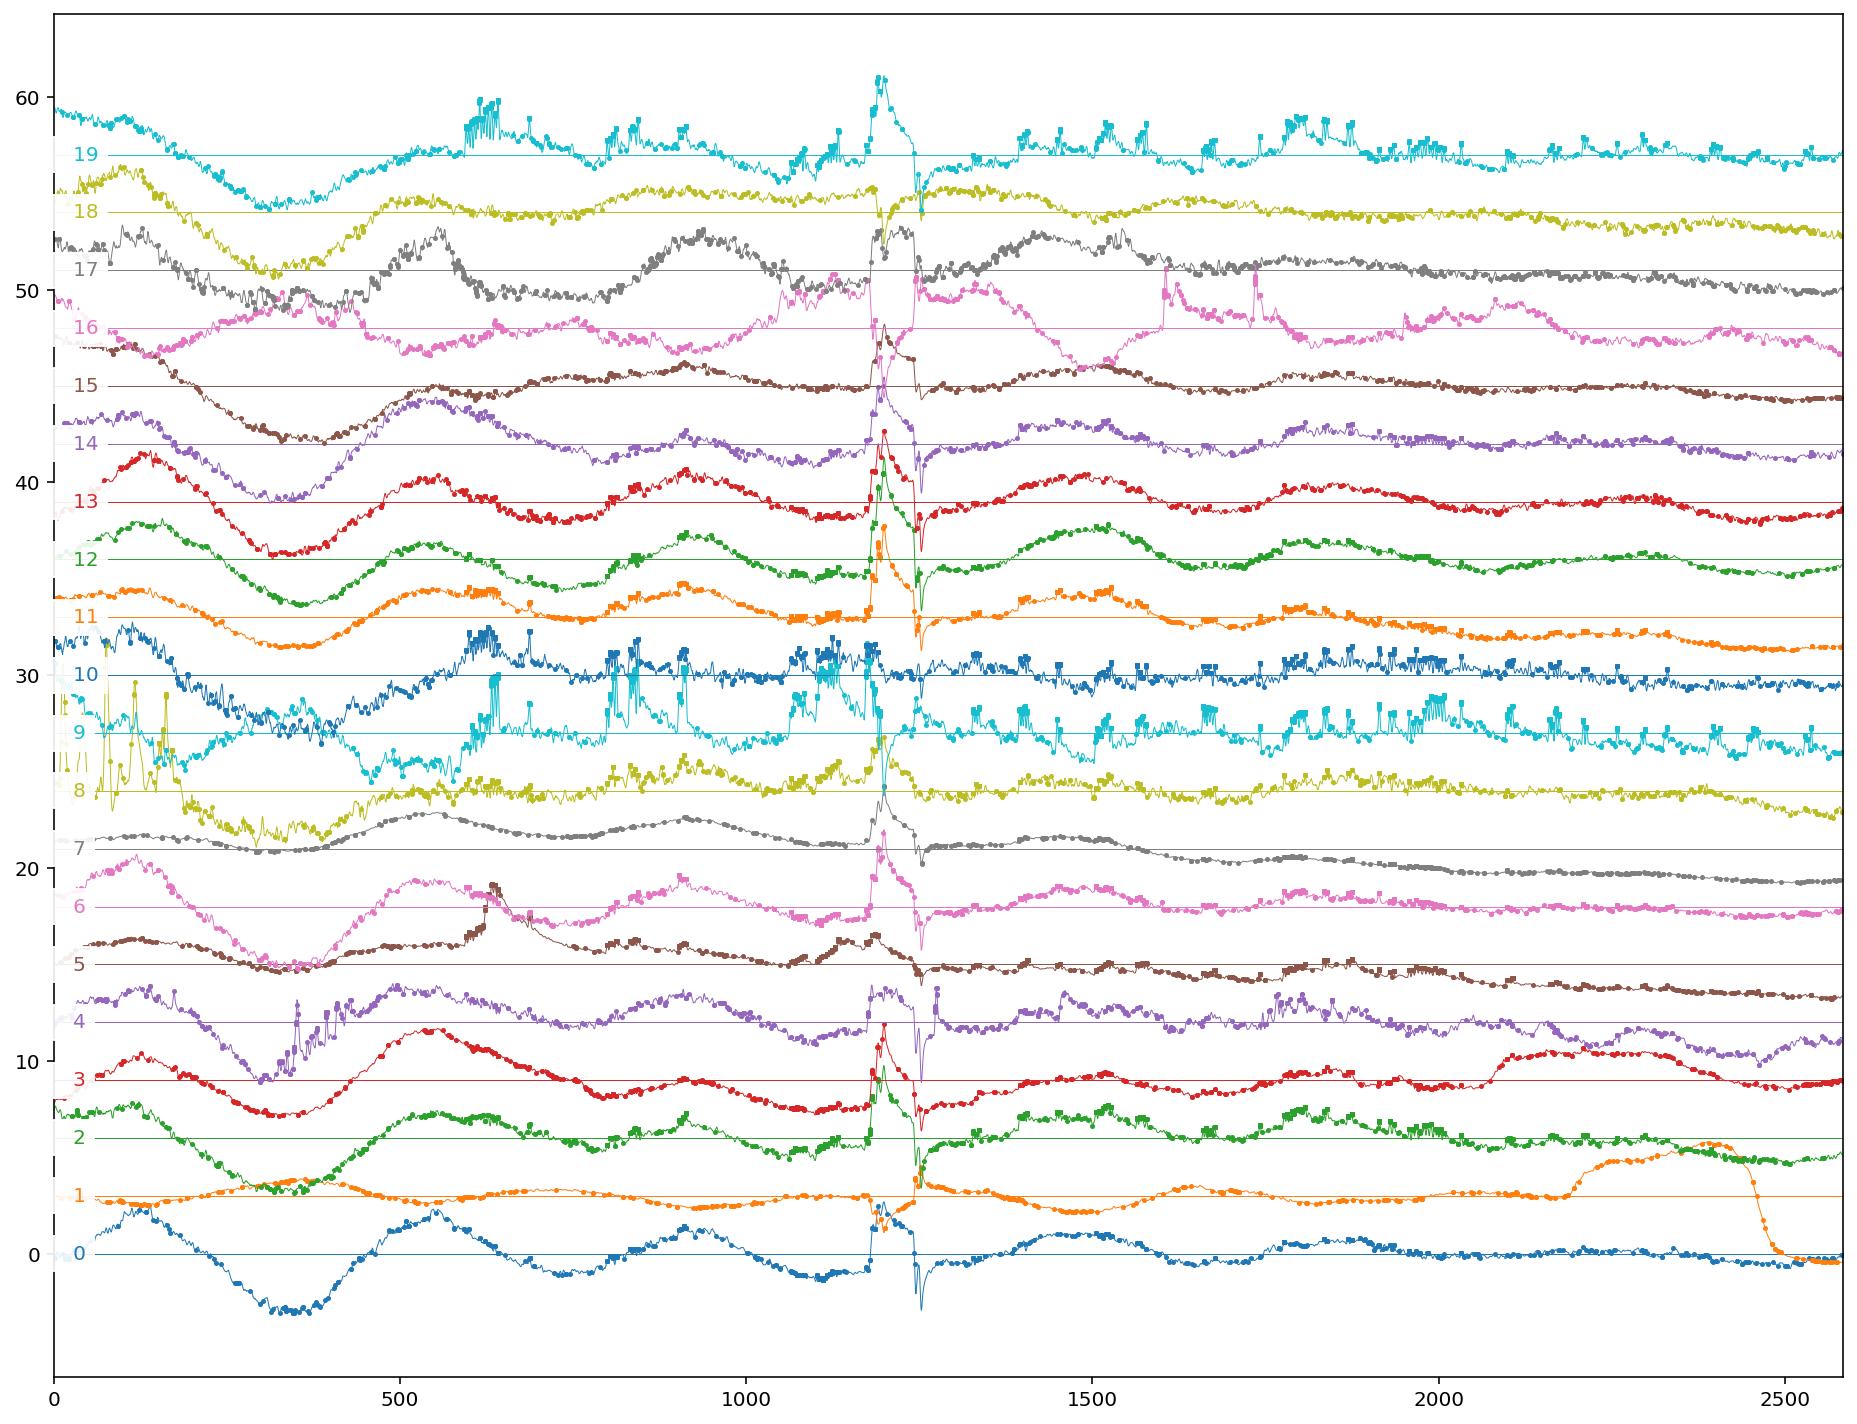

In [288]:
%%time
fig, axs = plt.subplots(1,1,figsize=(13,10), sharex=True)
axs = [axs]
ia = 0
# for i in [0,1,3,4,5,9]:
for i in range(20):
    j = C.sort_values("size",ascending=False).index[i]
    c = "C%i"%i
    xs = C.loc[j,"slower_2.5"].copy()
    xfoffset = ia*3
    xf = C.loc[j,"faster_2.5"].copy() 
    
    xsf = decayfit(xs)
    xs = xs - xsf
    xs = (xs - xs.mean())/xs.std()
    xs += xfoffset
    axs[0].plot(time, xs,c=c,lw=.5)
    
    n = 5
    xfa = runningAverage(xf,n)
    xfastd = -percFilter(xfa[::n],15.8,wIron*3)
    xfastd = np.repeat(xfastd,n)
#     axs[1].plot(time, xfa+ xfoffset,c=c,lw=.5,alpha = .7)
    ns = 3
#     axs[1].plot(time, xfoffset + ns*xfastd,c=c,lw=.5,alpha = .7)
#     axs[1].plot(time, xfoffset - ns*xfastd,c=c,lw=.5,alpha = .7)
    flt = xfa>ns*xfastd
    axs[0].plot(time[flt], xs[flt],".",c=c, ms=3)
    axs[0].axhline(xfoffset,c=c,lw=.5,)
    t = axs[0].text(0,xfoffset,"   "+str(i),color=c,va="center")
    t.set_bbox(dict(facecolor='w', alpha=0.9, edgecolor="w"))
    ia += 1
#     if ia>=2: break
axs[-1].set_xlim(0,time.max())
fig.tight_layout()

<IPython.core.display.Javascript object>


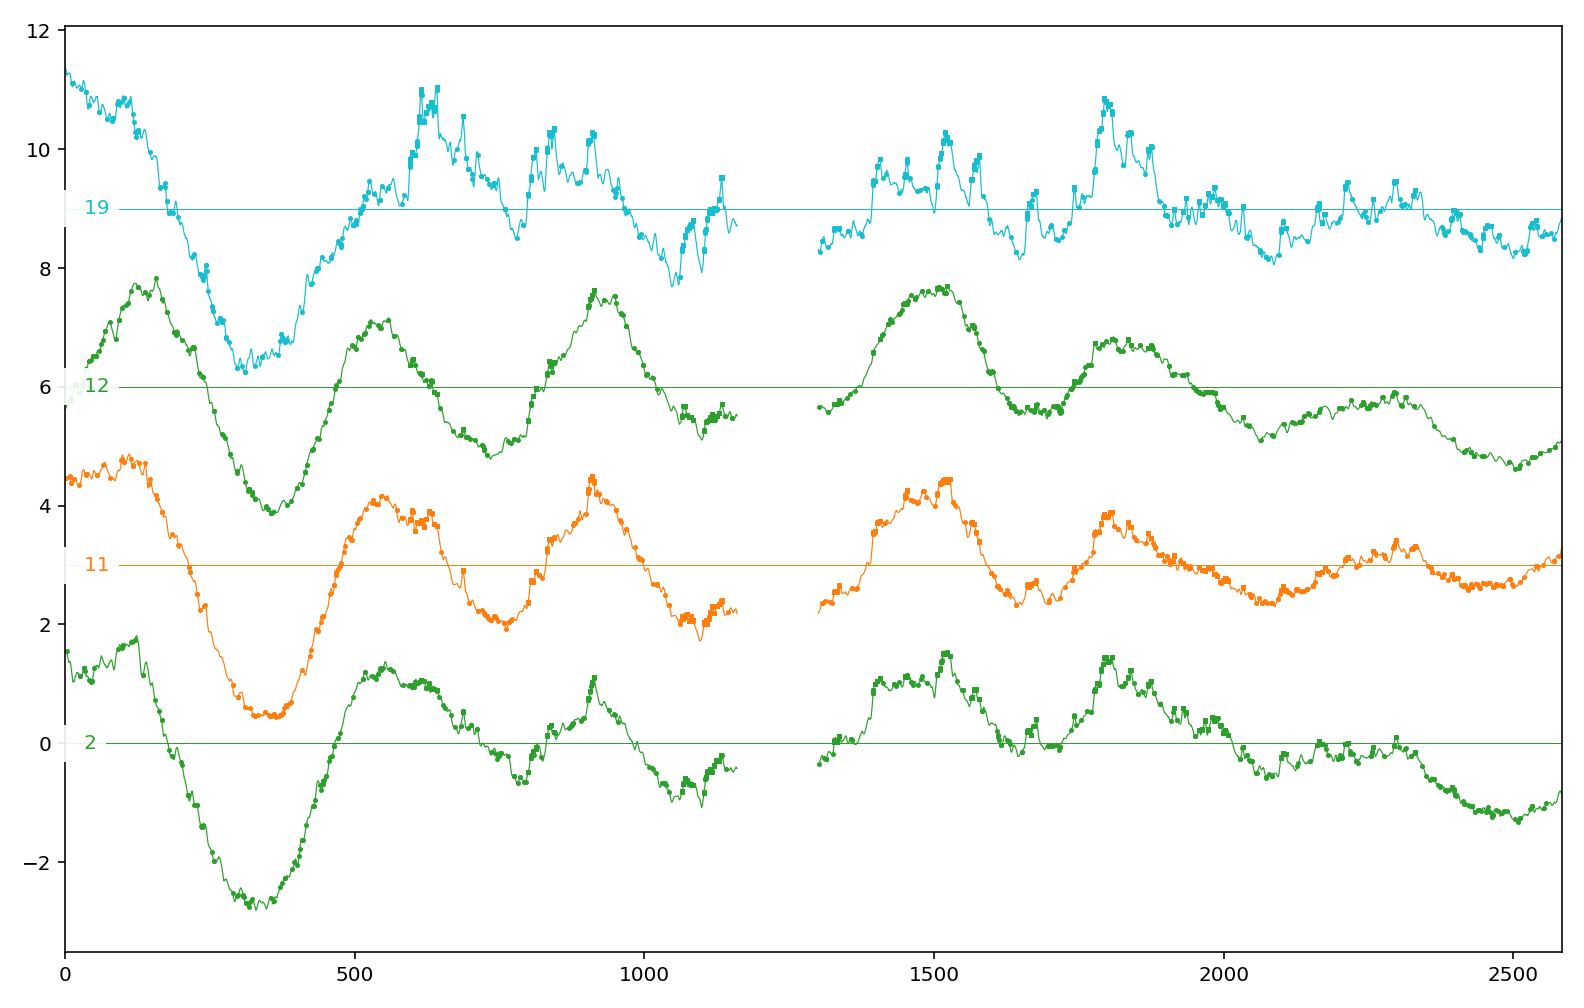

CPU times: user 23 s, sys: 2.82 ms, total: 23 s
Wall time: 23 s


In [277]:
%%time
fig, axs = plt.subplots(1,1,figsize=(11,7), sharex=True)
axs = [axs]
ia = 0
for i in [2,11,12,19]:
# for i in range(20):
    j = C.sort_values("size",ascending=False).index[i]
    c = "C%i"%i
    xs = C.loc[j,"slower_4"].copy()
    xfoffset = ia*3
    xf = C.loc[j,"faster_4"].copy() 
    
    xsf = decayfit(xs)
    xs = xs - xsf
    xs = (xs - xs.mean())/xs.std()
    xs += xfoffset
    n = 5
    xfa = runningAverage(xf,n)
    xfastd = -percFilter(xfa[::n],15.8,wIron*3)
    xfastd = np.repeat(xfastd,n)
#     axs[1].plot(time, xfa+ xfoffset,c=c,lw=.5,alpha = .7)
    ns = 3.
#     axs[1].plot(time, xfoffset + ns*xfastd,c=c,lw=.5,alpha = .7)
#     axs[1].plot(time, xfoffset - ns*xfastd,c=c,lw=.5,alpha = .7)
    flt = xfa>ns*xfastd
    tmp = np.ones_like(xs)*np.nan
    tmp[time<1160] = xs[time<1160]
    tmp[time>1300] = xs[time>1300]
    xs = tmp
    axs[0].plot(time, xs,c=c,lw=.6)
    axs[0].plot(time[flt], xs[flt],".",c=c, ms=3)
    axs[0].axhline(xfoffset,c=c,lw=.5,)
    t = axs[0].text(0,xfoffset,"   "+str(i),color=c,va="center")
    t.set_bbox(dict(facecolor='w', alpha=0.9, edgecolor="w"))
    ia += 1
#     if ia>=1: break
axs[-1].set_xlim(0,time.max())
fig.tight_layout()

### Analyze crawling

In [78]:
CorM = np.corrcoef(np.vstack(C["trace"]))

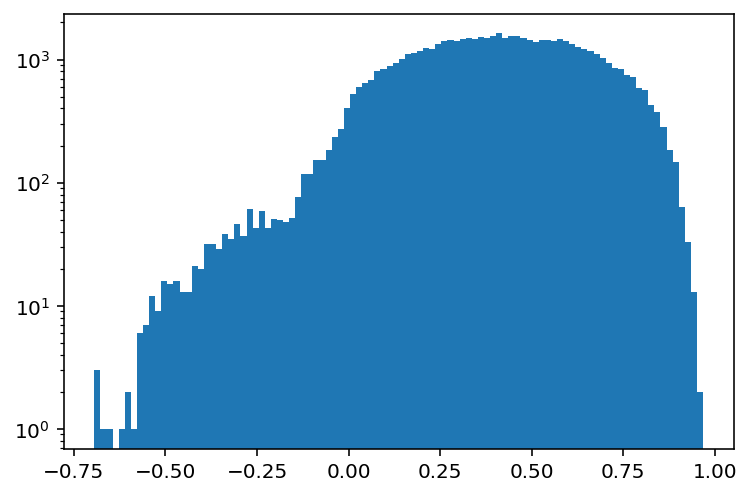

In [79]:
x = CorM[np.triu_indices_from(CorM,1)]
plt.hist(x,100,
         log=True
        );

In [498]:
np.argpartition?

In [505]:
np.argsort(-x)[:10]

array([ 85112,  85038, 124800,  85225,  85128, 143878,  85508,  91521,
       125180, 131652])

In [538]:
np.sum(x>0.85)

5

In [509]:
n = 10
iix = sorted(np.argpartition(-x,n,)[:n], key=lambda xi: -x[xi])

In [534]:
tmp = []
for i in iix:
    tmp += [np.linalg.norm(np.diff(np.vstack(C.loc[np.unique(np.squeeze(np.where(CorM==x[i]))),"center"].values),axis=0))]

In [535]:
tmp

[40.311288741492746,
 4.47213595499958,
 3.605551275463989,
 59.464274989274024,
 43.9089968002003,
 2.0,
 108.2266141020775,
 42.95346318982906,
 116.82465493208187,
 118.00423721205946]

In [539]:
# C.loc[np.squeeze(np.where(CorM==x.max()))]

In [540]:
# np.where(CorM==CorM.max())

In [449]:
C["trace_detrend"] = [dMovie[:,
    [el[0] for el in C.loc[i,"hood"]],
    [el[1] for el in C.loc[i,"hood"]]
       ].mean(axis=1) for i in C.index]

In [456]:
C["trace_trend"] = [m_50[:,
    [el[0] for el in C.loc[i,"hood"]],
    [el[1] for el in C.loc[i,"hood"]]
       ].mean(axis=1) for i in C.index]

In [546]:
Traces = np.vstack(C.query("size>5")[["trace_trend","size"]].prod(axis=1))
Traces = rebin(Traces,100,axis=1)

In [547]:
Traces.shape

(447, 303)

In [548]:
CorM = np.corrcoef(Traces[:,:])
CorM.shape

(447, 447)

In [453]:
%matplotlib inline

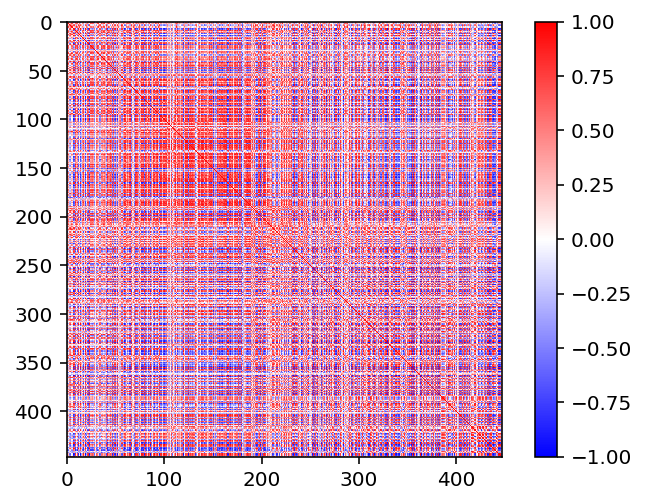

In [549]:
plt.imshow(CorM, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()

In [470]:
def distF(xi):
    return 1-np.corrcoef(xi)

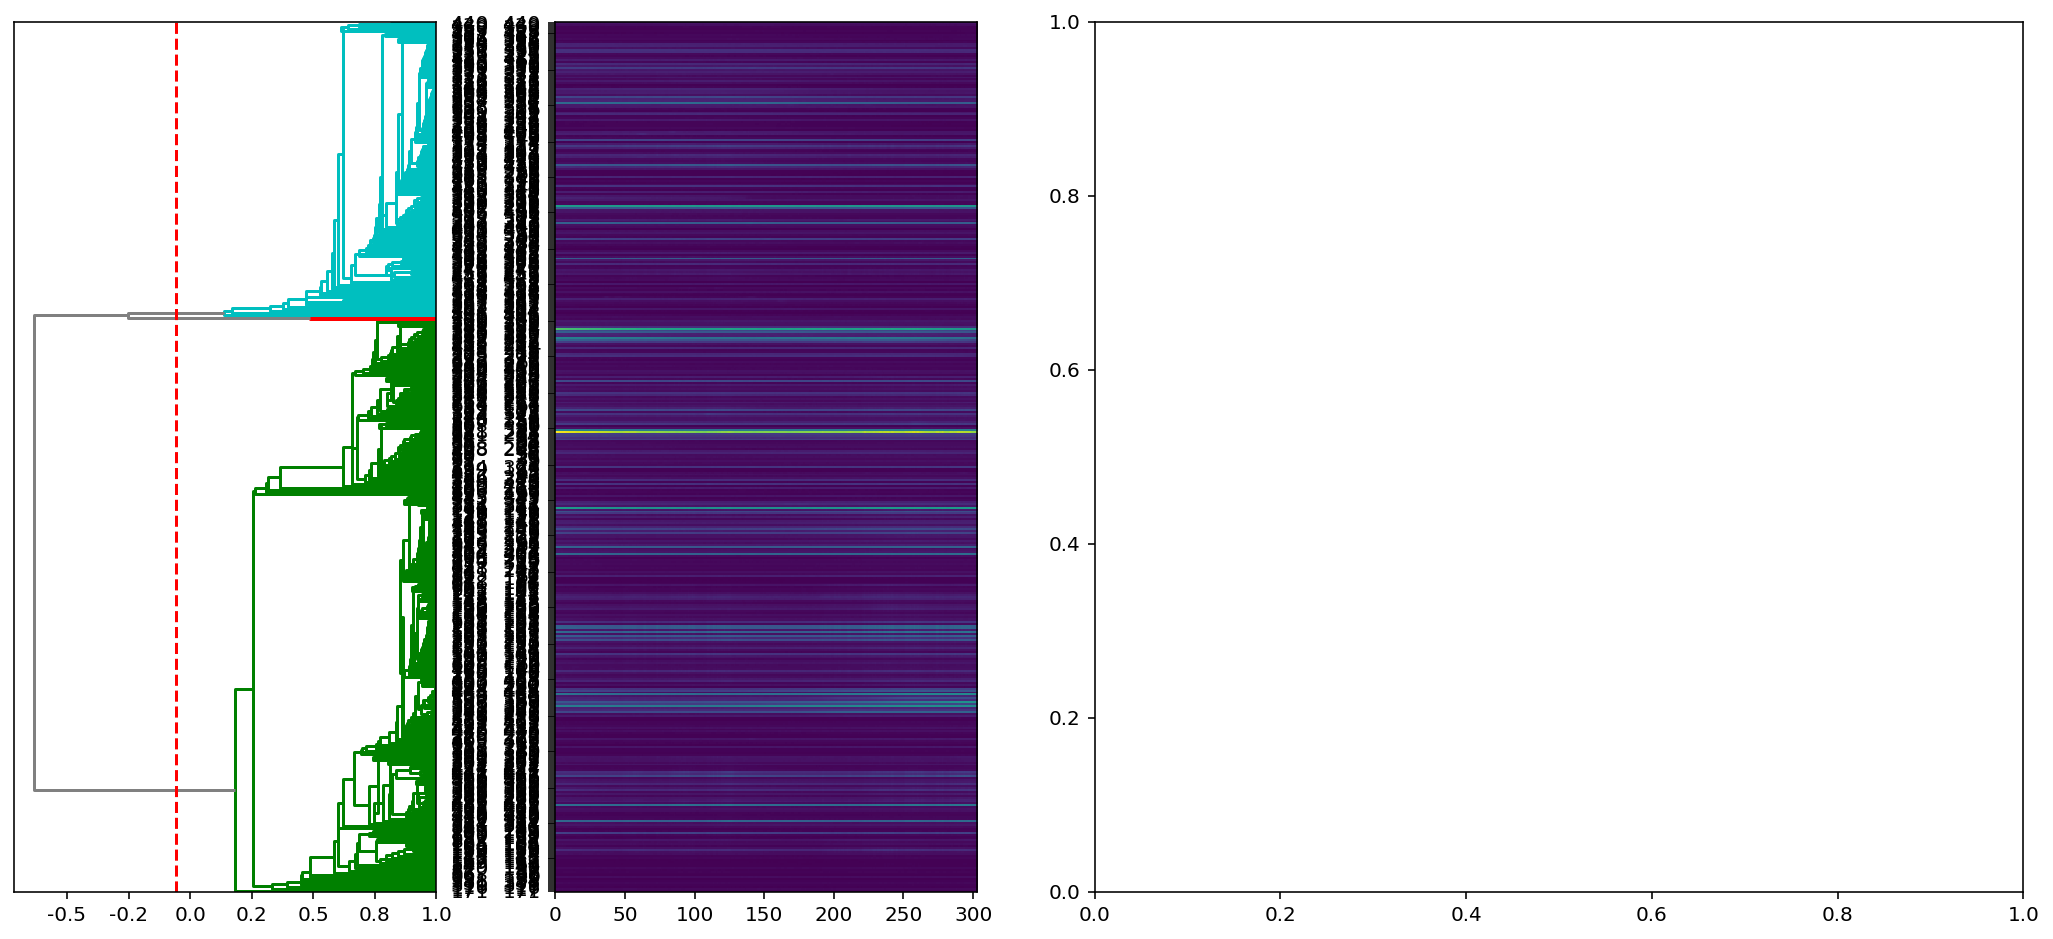

In [555]:
# Xcluster = np.diff(Traces[:],axis=1)
Xcluster = Traces
# Xcluster = np.array([(t-t.mean())/t.std() for t in Xcluster])
clRes = clusterCutAndPlot(Xcluster,
                      function=agglomerativeLinkage,
                      functionArgs=(distF,),
#                       function=linkage,
#                       functionArgs=("complete","correlation"),
                      threshold=3,
#                       criterion="maxclust",
#                       labels=None,
#                       imshow_kw = dict(), #vmin=-vmax,vmax=vmax, cmap="bwr"
#                       showClusterBoundaries=False,
                      )

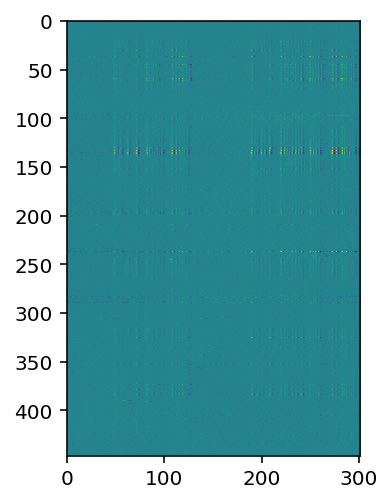

In [558]:
plt.imshow(np.diff(Xcluster[clRes["dendrogram"]["leaves"]],axis=1))